In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
n_channels = 16
alpha = 0.1

In [ ]:
def load_image(filename):
    img = tf.keras.preprocessing.image.load_img(path=filename, color_mode='rgba', target_size=(64, 64))
    img = np.array(img) / 255.0
    chars = np.zeros((64, 64, 12), dtype=np.float32)
    img = np.append(img, chars, axis=2)
    img = tf.expand_dims(img, 0)
    return img

def rgba(x):
    return x[0, :, :, :4]

def rgb(x):
  rgb, a = x[0, :, :, :3], tf.clip_by_value(x[0, :, :, 3:4], 0.0, 1.0)
  return 1.0-a+rgb

def plot(x):
    plt.imshow(rgb(x))
    plt.show()

def save_plot(x, filename):
    plt.imshow(rgb(x))
    plt.savefig('.\Imgs\Epoch ' + str(filename) + '.png')

def get_living_mask(x):
    channel_alpha = x[:, :, :, 3:4]
    return tf.nn.max_pool2d(channel_alpha, 3, [1, 1, 1, 1], 'SAME') > alpha

In [ ]:
class NNA(tf.keras.Model):

    def __init__(self, n_channels):
        super().__init__()
        self.channel_n = n_channels
        self.alpha = alpha

        self.dmodel = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 1, activation=tf.nn.relu),
            tf.keras.layers.Conv2D(self.channel_n, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        self(tf.zeros([1, 3, 3, n_channels]))

    def perceive(self, x):
        cellID = tf.constant([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]], dtype=tf.float32)
        sobelX = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
        sobelY = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)

        kernel = tf.stack([cellID, sobelX, sobelY], -1)[:, :, None, :]
        kernel = tf.repeat(kernel, self.channel_n, 2)

        y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
        return y

    def call(self, x, steps = 1):
        pre_live_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y) * steps

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= 0.5
        x += dx * tf.cast(update_mask, tf.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_live_mask & post_life_mask
        return x * tf.cast(life_mask, tf.float32)

In [ ]:
model = NNA(n_channels)

In [ ]:
lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([5000], [lr, lr*0.05])
optimizer = tf.keras.optimizers.Adam(lr_sched)
loss_object = tf.keras.losses.MeanSquaredError()

In [ ]:
IMG = load_image("export/frame_00159.png")

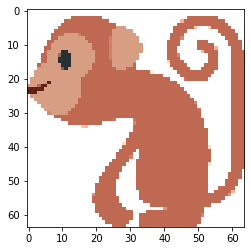

In [ ]:
plot(IMG)

In [ ]:
def loss_f(x):
    return loss_object(rgba(IMG), rgba(x))

def train_step(x):
    n = tf.random.uniform([],64,96,tf.int32)
    with tf.GradientTape() as g:
        for i in tf.range(n):
            x = model(x)
        loss = loss_f(x) * 100
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

In [ ]:
def init_image():
    img = np.zeros((64, 64 , 4), dtype=np.float32)
    chars = np.zeros((64, 64, 12), dtype=np.float32)
    img = np.append(img, chars, axis=2)
    img[32,32,3:] = 1
    img = tf.expand_dims(img, 0)
    return img

In [ ]:
x0 = init_image()

Epoch 1, Loss: 25.947349548339844


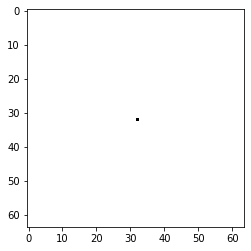

Epoch 2, Loss: 30.35643768310547
Epoch 3, Loss: 45.11866760253906
Epoch 4, Loss: 25.099956512451172
Epoch 5, Loss: 24.26294708251953
Epoch 6, Loss: 21.455230712890625
Epoch 7, Loss: 20.20989418029785
Epoch 8, Loss: 19.94277000427246
Epoch 9, Loss: 23.82619285583496
Epoch 10, Loss: 23.12544822692871
Epoch 11, Loss: 20.530895233154297
Epoch 12, Loss: 20.633874893188477
Epoch 13, Loss: 19.127452850341797
Epoch 14, Loss: 19.568078994750977
Epoch 15, Loss: 36.40264892578125
Epoch 16, Loss: 19.350971221923828
Epoch 17, Loss: 20.35321807861328
Epoch 18, Loss: 19.920778274536133
Epoch 19, Loss: 19.507234573364258
Epoch 20, Loss: 16.997705459594727
Epoch 21, Loss: 20.357933044433594
Epoch 22, Loss: 18.50395965576172
Epoch 23, Loss: 14.85247802734375
Epoch 24, Loss: 16.80060577392578
Epoch 25, Loss: 18.8234920501709


Epoch 26, Loss: 17.183679580688477


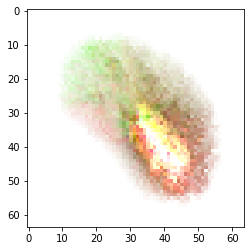

Epoch 27, Loss: 17.2825984954834
Epoch 28, Loss: 13.87511920928955
Epoch 29, Loss: 12.787832260131836
Epoch 30, Loss: 13.569534301757812
Epoch 31, Loss: 13.621175765991211
Epoch 32, Loss: 13.3347749710083
Epoch 33, Loss: 18.64678955078125
Epoch 34, Loss: 12.028696060180664
Epoch 35, Loss: 11.528623580932617
Epoch 36, Loss: 14.429839134216309
Epoch 37, Loss: 12.583968162536621
Epoch 38, Loss: 13.865758895874023
Epoch 39, Loss: 12.527050018310547
Epoch 40, Loss: 15.299236297607422
Epoch 41, Loss: 15.31651496887207
Epoch 42, Loss: 11.103227615356445
Epoch 43, Loss: 12.729287147521973
Epoch 44, Loss: 10.007503509521484
Epoch 45, Loss: 10.672926902770996
Epoch 46, Loss: 13.336017608642578
Epoch 47, Loss: 12.961668014526367
Epoch 48, Loss: 12.118658065795898
Epoch 49, Loss: 12.653613090515137
Epoch 50, Loss: 23.690567016601562


Epoch 51, Loss: 11.061792373657227


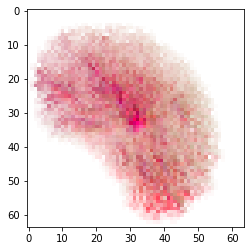

Epoch 52, Loss: 13.988792419433594
Epoch 53, Loss: 11.133218765258789
Epoch 54, Loss: 9.50888729095459
Epoch 55, Loss: 18.293672561645508
Epoch 56, Loss: 18.883121490478516
Epoch 57, Loss: 13.89930534362793
Epoch 58, Loss: 14.63051700592041
Epoch 59, Loss: 14.7139310836792
Epoch 60, Loss: 14.22421646118164
Epoch 61, Loss: 18.856557846069336
Epoch 62, Loss: 11.157190322875977
Epoch 63, Loss: 11.826519966125488
Epoch 64, Loss: 12.275016784667969
Epoch 65, Loss: 14.874333381652832
Epoch 66, Loss: 13.648232460021973
Epoch 67, Loss: 10.714262008666992
Epoch 68, Loss: 10.071587562561035
Epoch 69, Loss: 11.100759506225586
Epoch 70, Loss: 14.071258544921875
Epoch 71, Loss: 10.369688034057617
Epoch 72, Loss: 9.733162879943848
Epoch 73, Loss: 23.289438247680664
Epoch 74, Loss: 12.089252471923828
Epoch 75, Loss: 19.42715072631836


Epoch 76, Loss: 12.900980949401855


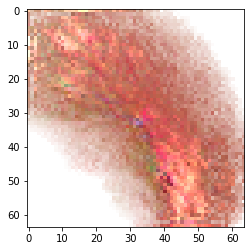

Epoch 77, Loss: 10.279953002929688
Epoch 78, Loss: 12.464794158935547
Epoch 79, Loss: 16.39950180053711
Epoch 80, Loss: 12.014640808105469
Epoch 81, Loss: 13.88282585144043
Epoch 82, Loss: 10.03164005279541
Epoch 83, Loss: 27.943479537963867
Epoch 84, Loss: 51.97685241699219
Epoch 85, Loss: 43.9676399230957
Epoch 86, Loss: 13.990160942077637
Epoch 87, Loss: 18.530452728271484
Epoch 88, Loss: 11.344376564025879
Epoch 89, Loss: 11.82896614074707
Epoch 90, Loss: 14.141735076904297
Epoch 91, Loss: 16.156797409057617
Epoch 92, Loss: 10.983671188354492
Epoch 93, Loss: 10.964491844177246
Epoch 94, Loss: 10.723987579345703
Epoch 95, Loss: 11.020886421203613
Epoch 96, Loss: 33.66824722290039
Epoch 97, Loss: 84.65872955322266
Epoch 98, Loss: 38.48618698120117
Epoch 99, Loss: 105.68721008300781
Epoch 100, Loss: 10.179634094238281


Epoch 101, Loss: 10.227291107177734


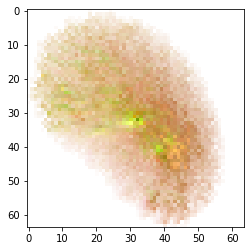

Epoch 102, Loss: 10.964595794677734
Epoch 103, Loss: 9.982418060302734
Epoch 104, Loss: 11.978876113891602
Epoch 105, Loss: 13.10378646850586
Epoch 106, Loss: 12.735869407653809
Epoch 107, Loss: 10.323440551757812
Epoch 108, Loss: 10.682971000671387
Epoch 109, Loss: 11.342856407165527
Epoch 110, Loss: 32.24412536621094
Epoch 111, Loss: 24.64269256591797
Epoch 112, Loss: 25.025314331054688
Epoch 113, Loss: 21.42241668701172
Epoch 114, Loss: 11.508708953857422
Epoch 115, Loss: 9.903164863586426
Epoch 116, Loss: 9.557184219360352
Epoch 117, Loss: 10.01021957397461
Epoch 118, Loss: 13.741621017456055
Epoch 119, Loss: 11.720437049865723
Epoch 120, Loss: 12.892653465270996
Epoch 121, Loss: 11.765039443969727
Epoch 122, Loss: 11.061978340148926
Epoch 123, Loss: 10.489450454711914
Epoch 124, Loss: 13.016301155090332
Epoch 125, Loss: 11.93594741821289


Epoch 126, Loss: 9.869839668273926


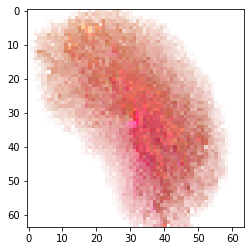

Epoch 127, Loss: 10.34223747253418
Epoch 128, Loss: 19.54815673828125
Epoch 129, Loss: 24.981971740722656
Epoch 130, Loss: 13.614404678344727
Epoch 131, Loss: 13.226951599121094
Epoch 132, Loss: 9.821325302124023
Epoch 133, Loss: 10.07496166229248
Epoch 134, Loss: 9.918500900268555
Epoch 135, Loss: 15.5636625289917
Epoch 136, Loss: 10.079373359680176
Epoch 137, Loss: 10.36734390258789
Epoch 138, Loss: 10.444352149963379
Epoch 139, Loss: 11.454436302185059
Epoch 140, Loss: 18.274372100830078
Epoch 141, Loss: 33.45500564575195
Epoch 142, Loss: 44.36024856567383
Epoch 143, Loss: 11.735014915466309
Epoch 144, Loss: 10.706421852111816
Epoch 145, Loss: 10.412473678588867
Epoch 146, Loss: 9.417223930358887
Epoch 147, Loss: 13.429427146911621
Epoch 148, Loss: 9.156572341918945
Epoch 149, Loss: 12.656622886657715
Epoch 150, Loss: 9.503210067749023


Epoch 151, Loss: 11.298072814941406


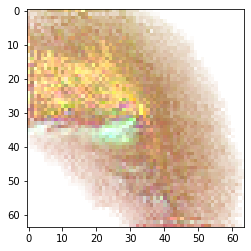

Epoch 152, Loss: 9.114880561828613
Epoch 153, Loss: 10.374282836914062
Epoch 154, Loss: 10.303518295288086
Epoch 155, Loss: 12.247085571289062
Epoch 156, Loss: 14.579662322998047
Epoch 157, Loss: 11.272649765014648
Epoch 158, Loss: 9.434844970703125
Epoch 159, Loss: 11.319116592407227
Epoch 160, Loss: 9.184471130371094
Epoch 161, Loss: 8.812005996704102
Epoch 162, Loss: 10.56771183013916
Epoch 163, Loss: 9.674911499023438
Epoch 164, Loss: 9.059611320495605
Epoch 165, Loss: 12.358551025390625
Epoch 166, Loss: 11.146910667419434
Epoch 167, Loss: 8.402935028076172
Epoch 168, Loss: 9.670166969299316
Epoch 169, Loss: 8.888809204101562
Epoch 170, Loss: 13.056678771972656
Epoch 171, Loss: 10.437742233276367
Epoch 172, Loss: 8.986515998840332
Epoch 173, Loss: 9.05793571472168
Epoch 174, Loss: 12.348377227783203
Epoch 175, Loss: 8.539361953735352


Epoch 176, Loss: 8.702129364013672


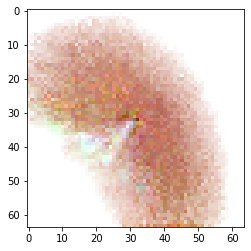

Epoch 177, Loss: 8.913223266601562
Epoch 178, Loss: 11.641639709472656
Epoch 179, Loss: 9.686104774475098
Epoch 180, Loss: 9.865181922912598
Epoch 181, Loss: 8.966325759887695
Epoch 182, Loss: 8.388239860534668
Epoch 183, Loss: 7.988824844360352
Epoch 184, Loss: 9.429902076721191
Epoch 185, Loss: 8.604571342468262
Epoch 186, Loss: 9.958991050720215
Epoch 187, Loss: 10.170793533325195
Epoch 188, Loss: 8.794475555419922
Epoch 189, Loss: 11.479046821594238
Epoch 190, Loss: 8.588044166564941
Epoch 191, Loss: 9.128649711608887
Epoch 192, Loss: 9.527310371398926
Epoch 193, Loss: 7.922727584838867
Epoch 194, Loss: 11.262214660644531
Epoch 195, Loss: 9.481840133666992
Epoch 196, Loss: 9.592293739318848
Epoch 197, Loss: 8.380001068115234
Epoch 198, Loss: 9.089241981506348
Epoch 199, Loss: 8.769408226013184
Epoch 200, Loss: 8.60876178741455


Epoch 201, Loss: 8.73033332824707


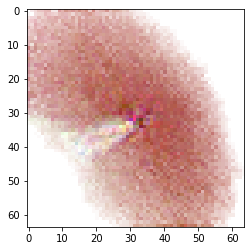

Epoch 202, Loss: 12.510761260986328
Epoch 203, Loss: 13.25579833984375
Epoch 204, Loss: 9.63569450378418
Epoch 205, Loss: 9.669146537780762
Epoch 206, Loss: 10.628769874572754
Epoch 207, Loss: 15.076454162597656
Epoch 208, Loss: 10.364729881286621
Epoch 209, Loss: 11.058907508850098
Epoch 210, Loss: 12.979849815368652
Epoch 211, Loss: 11.369646072387695
Epoch 212, Loss: 8.34866714477539
Epoch 213, Loss: 9.833416938781738
Epoch 214, Loss: 8.75094985961914
Epoch 215, Loss: 8.271825790405273
Epoch 216, Loss: 9.233436584472656
Epoch 217, Loss: 8.402583122253418
Epoch 218, Loss: 8.433818817138672
Epoch 219, Loss: 9.801162719726562
Epoch 220, Loss: 9.551056861877441
Epoch 221, Loss: 8.075095176696777
Epoch 222, Loss: 8.962736129760742
Epoch 223, Loss: 8.333741188049316
Epoch 224, Loss: 13.248109817504883
Epoch 225, Loss: 9.63318920135498


Epoch 226, Loss: 8.530628204345703


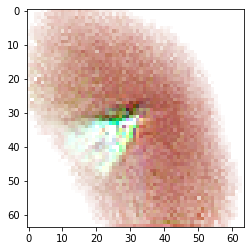

Epoch 227, Loss: 9.063645362854004
Epoch 228, Loss: 8.726580619812012
Epoch 229, Loss: 8.576443672180176
Epoch 230, Loss: 10.323299407958984
Epoch 231, Loss: 10.868622779846191
Epoch 232, Loss: 9.707345008850098
Epoch 233, Loss: 8.195344924926758
Epoch 234, Loss: 9.461126327514648
Epoch 235, Loss: 11.564133644104004
Epoch 236, Loss: 8.457948684692383
Epoch 237, Loss: 8.135289192199707
Epoch 238, Loss: 11.017708778381348
Epoch 239, Loss: 8.041581153869629
Epoch 240, Loss: 7.967224597930908
Epoch 241, Loss: 9.122983932495117
Epoch 242, Loss: 12.758130073547363
Epoch 243, Loss: 12.009593963623047
Epoch 244, Loss: 11.265880584716797
Epoch 245, Loss: 14.170198440551758
Epoch 246, Loss: 9.563286781311035
Epoch 247, Loss: 8.925705909729004
Epoch 248, Loss: 9.528456687927246
Epoch 249, Loss: 12.80465316772461
Epoch 250, Loss: 9.444550514221191


Epoch 251, Loss: 9.122106552124023


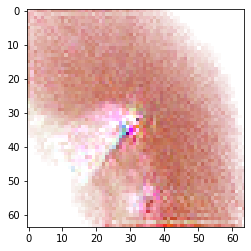

Epoch 252, Loss: 9.045135498046875
Epoch 253, Loss: 9.747781753540039
Epoch 254, Loss: 8.96416187286377
Epoch 255, Loss: 8.702960014343262
Epoch 256, Loss: 8.72370719909668
Epoch 257, Loss: 12.327654838562012
Epoch 258, Loss: 11.5361328125
Epoch 259, Loss: 11.978321075439453
Epoch 260, Loss: 10.541389465332031
Epoch 261, Loss: 10.469537734985352
Epoch 262, Loss: 11.833168983459473
Epoch 263, Loss: 9.584080696105957
Epoch 264, Loss: 18.415882110595703
Epoch 265, Loss: 10.276458740234375
Epoch 266, Loss: 12.240753173828125
Epoch 267, Loss: 9.484732627868652
Epoch 268, Loss: 9.53825855255127
Epoch 269, Loss: 8.948173522949219
Epoch 270, Loss: 9.031346321105957
Epoch 271, Loss: 10.442913055419922
Epoch 272, Loss: 13.174501419067383
Epoch 273, Loss: 9.456762313842773
Epoch 274, Loss: 8.891018867492676
Epoch 275, Loss: 9.55676555633545


Epoch 276, Loss: 8.659256935119629


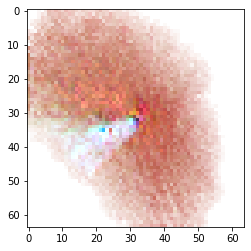

Epoch 277, Loss: 8.610787391662598
Epoch 278, Loss: 9.013104438781738
Epoch 279, Loss: 9.731574058532715
Epoch 280, Loss: 8.769091606140137
Epoch 281, Loss: 8.514328956604004
Epoch 282, Loss: 9.335424423217773
Epoch 283, Loss: 11.652220726013184
Epoch 284, Loss: 9.06589126586914
Epoch 285, Loss: 9.136855125427246
Epoch 286, Loss: 9.461816787719727
Epoch 287, Loss: 10.036763191223145
Epoch 288, Loss: 9.007471084594727
Epoch 289, Loss: 8.357101440429688
Epoch 290, Loss: 8.480680465698242
Epoch 291, Loss: 8.54053020477295
Epoch 292, Loss: 9.431411743164062
Epoch 293, Loss: 8.424735069274902
Epoch 294, Loss: 8.60331916809082
Epoch 295, Loss: 9.538104057312012
Epoch 296, Loss: 8.6032075881958
Epoch 297, Loss: 10.577430725097656
Epoch 298, Loss: 12.654640197753906
Epoch 299, Loss: 9.726985931396484
Epoch 300, Loss: 8.401440620422363


Epoch 301, Loss: 9.07101821899414


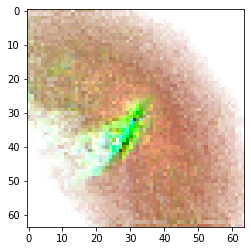

Epoch 302, Loss: 8.485029220581055
Epoch 303, Loss: 7.9569830894470215
Epoch 304, Loss: 10.04626750946045
Epoch 305, Loss: 8.32081413269043
Epoch 306, Loss: 8.715400695800781
Epoch 307, Loss: 11.510482788085938
Epoch 308, Loss: 8.14401912689209
Epoch 309, Loss: 8.030926704406738
Epoch 310, Loss: 12.066264152526855
Epoch 311, Loss: 10.356901168823242
Epoch 312, Loss: 9.428949356079102
Epoch 313, Loss: 9.273797988891602
Epoch 314, Loss: 11.918319702148438
Epoch 315, Loss: 10.601585388183594
Epoch 316, Loss: 8.715022087097168
Epoch 317, Loss: 8.866639137268066
Epoch 318, Loss: 8.723213195800781
Epoch 319, Loss: 8.646888732910156
Epoch 320, Loss: 8.29036808013916
Epoch 321, Loss: 9.788434982299805
Epoch 322, Loss: 8.450469970703125
Epoch 323, Loss: 11.396050453186035
Epoch 324, Loss: 8.50909423828125
Epoch 325, Loss: 8.604647636413574


Epoch 326, Loss: 8.514930725097656


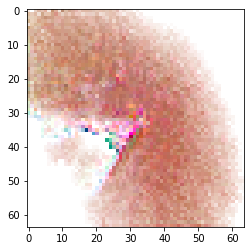

Epoch 327, Loss: 9.96515941619873
Epoch 328, Loss: 8.194339752197266
Epoch 329, Loss: 8.258358001708984
Epoch 330, Loss: 8.055048942565918
Epoch 331, Loss: 8.459502220153809
Epoch 332, Loss: 7.978450298309326
Epoch 333, Loss: 8.190568923950195
Epoch 334, Loss: 9.917680740356445
Epoch 335, Loss: 8.491491317749023
Epoch 336, Loss: 9.508039474487305
Epoch 337, Loss: 8.352438926696777
Epoch 338, Loss: 8.777849197387695
Epoch 339, Loss: 8.257842063903809
Epoch 340, Loss: 8.121867179870605
Epoch 341, Loss: 8.466913223266602
Epoch 342, Loss: 8.176074028015137
Epoch 343, Loss: 8.281034469604492
Epoch 344, Loss: 10.887372970581055
Epoch 345, Loss: 9.779359817504883
Epoch 346, Loss: 9.930656433105469
Epoch 347, Loss: 8.009734153747559
Epoch 348, Loss: 8.593265533447266
Epoch 349, Loss: 8.1150484085083
Epoch 350, Loss: 8.2140531539917


Epoch 351, Loss: 7.608657360076904


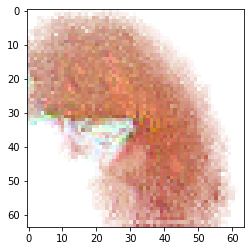

Epoch 352, Loss: 11.470813751220703
Epoch 353, Loss: 10.36422348022461
Epoch 354, Loss: 8.039749145507812
Epoch 355, Loss: 7.865075588226318
Epoch 356, Loss: 7.889927864074707
Epoch 357, Loss: 7.8001556396484375
Epoch 358, Loss: 8.331610679626465
Epoch 359, Loss: 8.16809368133545
Epoch 360, Loss: 9.43301773071289
Epoch 361, Loss: 8.511852264404297
Epoch 362, Loss: 9.54842758178711
Epoch 363, Loss: 8.324516296386719
Epoch 364, Loss: 7.751877784729004
Epoch 365, Loss: 10.047760963439941
Epoch 366, Loss: 8.570006370544434
Epoch 367, Loss: 8.77089786529541
Epoch 368, Loss: 8.20826530456543
Epoch 369, Loss: 8.838582992553711
Epoch 370, Loss: 10.61292839050293
Epoch 371, Loss: 7.731698989868164
Epoch 372, Loss: 9.854193687438965
Epoch 373, Loss: 8.363272666931152
Epoch 374, Loss: 8.140462875366211
Epoch 375, Loss: 9.72249698638916


Epoch 376, Loss: 8.388283729553223


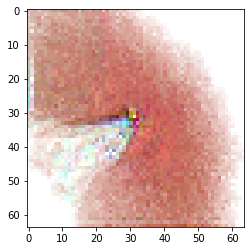

Epoch 377, Loss: 8.01264762878418
Epoch 378, Loss: 9.176996231079102
Epoch 379, Loss: 9.32064151763916
Epoch 380, Loss: 8.488364219665527
Epoch 381, Loss: 8.418302536010742
Epoch 382, Loss: 8.1996431350708
Epoch 383, Loss: 9.260281562805176
Epoch 384, Loss: 8.10279655456543
Epoch 385, Loss: 7.979445934295654
Epoch 386, Loss: 8.640076637268066
Epoch 387, Loss: 7.793447494506836
Epoch 388, Loss: 8.426068305969238
Epoch 389, Loss: 8.307374000549316
Epoch 390, Loss: 7.693007469177246
Epoch 391, Loss: 9.548982620239258
Epoch 392, Loss: 7.781294822692871
Epoch 393, Loss: 7.636351108551025
Epoch 394, Loss: 7.85009765625
Epoch 395, Loss: 7.759581565856934
Epoch 396, Loss: 8.929404258728027
Epoch 397, Loss: 7.858184814453125
Epoch 398, Loss: 9.2969970703125
Epoch 399, Loss: 8.864299774169922
Epoch 400, Loss: 8.017669677734375


Epoch 401, Loss: 9.368705749511719


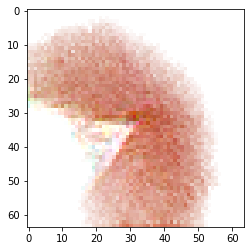

Epoch 402, Loss: 7.894070625305176
Epoch 403, Loss: 8.49524974822998
Epoch 404, Loss: 8.781574249267578
Epoch 405, Loss: 8.943777084350586
Epoch 406, Loss: 7.837635040283203
Epoch 407, Loss: 9.146729469299316
Epoch 408, Loss: 8.074140548706055
Epoch 409, Loss: 7.8535990715026855
Epoch 410, Loss: 7.552352428436279
Epoch 411, Loss: 8.17855453491211
Epoch 412, Loss: 7.772465229034424
Epoch 413, Loss: 7.885409355163574
Epoch 414, Loss: 7.617573261260986
Epoch 415, Loss: 9.611242294311523
Epoch 416, Loss: 7.850262641906738
Epoch 417, Loss: 9.424408912658691
Epoch 418, Loss: 8.922709465026855
Epoch 419, Loss: 8.311721801757812
Epoch 420, Loss: 8.022645950317383
Epoch 421, Loss: 8.008615493774414
Epoch 422, Loss: 7.565401554107666
Epoch 423, Loss: 7.3131537437438965
Epoch 424, Loss: 7.636739253997803
Epoch 425, Loss: 7.522207260131836


Epoch 426, Loss: 7.997189521789551


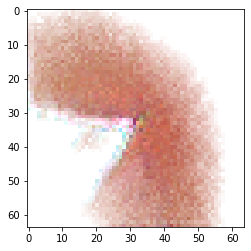

Epoch 427, Loss: 7.625790596008301
Epoch 428, Loss: 7.997270584106445
Epoch 429, Loss: 7.685530185699463
Epoch 430, Loss: 10.654312133789062
Epoch 431, Loss: 8.13613224029541
Epoch 432, Loss: 7.9884724617004395
Epoch 433, Loss: 8.782428741455078
Epoch 434, Loss: 9.214113235473633
Epoch 435, Loss: 7.704548358917236
Epoch 436, Loss: 8.04736614227295
Epoch 437, Loss: 12.07448673248291
Epoch 438, Loss: 8.09053897857666
Epoch 439, Loss: 9.559408187866211
Epoch 440, Loss: 9.898303031921387
Epoch 441, Loss: 9.983942985534668
Epoch 442, Loss: 8.340108871459961
Epoch 443, Loss: 10.416955947875977
Epoch 444, Loss: 8.378981590270996
Epoch 445, Loss: 7.959057331085205
Epoch 446, Loss: 8.130644798278809
Epoch 447, Loss: 8.37885570526123
Epoch 448, Loss: 8.30565071105957
Epoch 449, Loss: 8.47273063659668
Epoch 450, Loss: 10.040433883666992


Epoch 451, Loss: 8.343067169189453


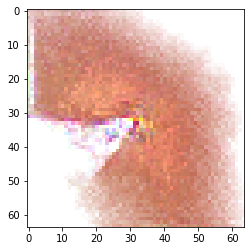

Epoch 452, Loss: 8.864089965820312
Epoch 453, Loss: 8.000388145446777
Epoch 454, Loss: 8.16134262084961
Epoch 455, Loss: 8.03717041015625
Epoch 456, Loss: 7.823854446411133
Epoch 457, Loss: 7.793789386749268
Epoch 458, Loss: 7.504793167114258
Epoch 459, Loss: 7.599571228027344
Epoch 460, Loss: 10.513922691345215
Epoch 461, Loss: 8.57259750366211
Epoch 462, Loss: 9.033394813537598
Epoch 463, Loss: 9.200735092163086
Epoch 464, Loss: 7.943202018737793
Epoch 465, Loss: 9.363351821899414
Epoch 466, Loss: 8.707294464111328
Epoch 467, Loss: 8.258801460266113
Epoch 468, Loss: 9.493009567260742
Epoch 469, Loss: 7.990538120269775
Epoch 470, Loss: 8.040399551391602
Epoch 471, Loss: 8.928004264831543
Epoch 472, Loss: 7.776588439941406
Epoch 473, Loss: 8.010937690734863
Epoch 474, Loss: 7.91247034072876
Epoch 475, Loss: 8.402128219604492


Epoch 476, Loss: 7.689125061035156


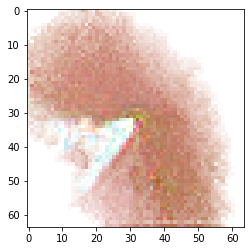

Epoch 477, Loss: 9.081021308898926
Epoch 478, Loss: 9.243053436279297
Epoch 479, Loss: 8.227560043334961
Epoch 480, Loss: 8.386345863342285
Epoch 481, Loss: 8.843528747558594
Epoch 482, Loss: 8.050167083740234
Epoch 483, Loss: 7.870157241821289
Epoch 484, Loss: 7.957124710083008
Epoch 485, Loss: 7.549887657165527
Epoch 486, Loss: 7.875167369842529
Epoch 487, Loss: 7.666665077209473
Epoch 488, Loss: 7.452092170715332
Epoch 489, Loss: 7.83000373840332
Epoch 490, Loss: 9.190861701965332
Epoch 491, Loss: 10.01179027557373
Epoch 492, Loss: 8.293619155883789
Epoch 493, Loss: 8.066604614257812
Epoch 494, Loss: 8.881961822509766
Epoch 495, Loss: 8.207295417785645
Epoch 496, Loss: 7.889878749847412
Epoch 497, Loss: 7.64674711227417
Epoch 498, Loss: 9.37647533416748
Epoch 499, Loss: 7.894182205200195
Epoch 500, Loss: 8.828842163085938


Epoch 501, Loss: 8.755989074707031


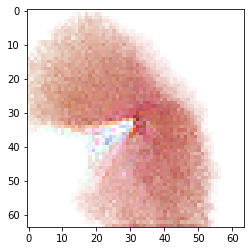

Epoch 502, Loss: 7.882782936096191
Epoch 503, Loss: 7.845561981201172
Epoch 504, Loss: 8.033409118652344
Epoch 505, Loss: 8.258559226989746
Epoch 506, Loss: 8.05731201171875
Epoch 507, Loss: 8.495280265808105
Epoch 508, Loss: 7.7346673011779785
Epoch 509, Loss: 8.912862777709961
Epoch 510, Loss: 7.7617011070251465
Epoch 511, Loss: 7.696232795715332
Epoch 512, Loss: 7.543271064758301
Epoch 513, Loss: 7.379498481750488
Epoch 514, Loss: 8.480114936828613
Epoch 515, Loss: 8.442740440368652
Epoch 516, Loss: 7.696905612945557
Epoch 517, Loss: 8.243785858154297
Epoch 518, Loss: 9.323147773742676
Epoch 519, Loss: 8.139854431152344
Epoch 520, Loss: 8.39728832244873
Epoch 521, Loss: 7.874818325042725
Epoch 522, Loss: 7.6520843505859375
Epoch 523, Loss: 7.56534481048584
Epoch 524, Loss: 7.437077045440674
Epoch 525, Loss: 7.4997382164001465


Epoch 526, Loss: 7.884013652801514


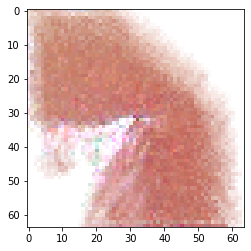

Epoch 527, Loss: 8.413591384887695
Epoch 528, Loss: 7.795439720153809
Epoch 529, Loss: 8.919797897338867
Epoch 530, Loss: 9.52365493774414
Epoch 531, Loss: 7.624174118041992
Epoch 532, Loss: 8.968274116516113
Epoch 533, Loss: 7.737504005432129
Epoch 534, Loss: 8.101492881774902
Epoch 535, Loss: 8.579333305358887
Epoch 536, Loss: 7.7490010261535645
Epoch 537, Loss: 8.04016399383545
Epoch 538, Loss: 7.4791178703308105
Epoch 539, Loss: 9.641053199768066
Epoch 540, Loss: 7.507929801940918
Epoch 541, Loss: 9.244034767150879
Epoch 542, Loss: 8.656987190246582
Epoch 543, Loss: 8.133106231689453
Epoch 544, Loss: 8.1025972366333
Epoch 545, Loss: 7.8775763511657715
Epoch 546, Loss: 10.621831893920898
Epoch 547, Loss: 8.518577575683594
Epoch 548, Loss: 7.943206310272217
Epoch 549, Loss: 9.298701286315918
Epoch 550, Loss: 7.837474346160889


Epoch 551, Loss: 8.787296295166016


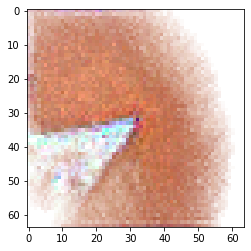

Epoch 552, Loss: 8.208808898925781
Epoch 553, Loss: 8.118639945983887
Epoch 554, Loss: 7.8260698318481445
Epoch 555, Loss: 8.026474952697754
Epoch 556, Loss: 7.38141393661499
Epoch 557, Loss: 7.4316253662109375
Epoch 558, Loss: 7.402651786804199
Epoch 559, Loss: 7.358956336975098
Epoch 560, Loss: 7.203251838684082
Epoch 561, Loss: 9.606966018676758
Epoch 562, Loss: 8.377083778381348
Epoch 563, Loss: 8.502214431762695
Epoch 564, Loss: 8.927289962768555
Epoch 565, Loss: 10.033724784851074
Epoch 566, Loss: 7.817514419555664
Epoch 567, Loss: 8.186527252197266
Epoch 568, Loss: 8.876829147338867
Epoch 569, Loss: 8.897716522216797
Epoch 570, Loss: 8.393705368041992
Epoch 571, Loss: 8.961719512939453
Epoch 572, Loss: 9.834856033325195
Epoch 573, Loss: 9.342323303222656
Epoch 574, Loss: 8.192933082580566
Epoch 575, Loss: 8.44402027130127


Epoch 576, Loss: 8.099267959594727


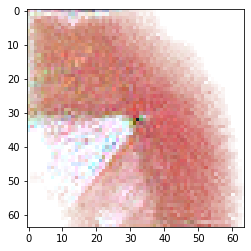

Epoch 577, Loss: 7.707704067230225
Epoch 578, Loss: 8.838810920715332
Epoch 579, Loss: 9.650355339050293
Epoch 580, Loss: 8.663454055786133
Epoch 581, Loss: 8.189376831054688
Epoch 582, Loss: 7.84169340133667
Epoch 583, Loss: 9.939998626708984
Epoch 584, Loss: 8.110221862792969
Epoch 585, Loss: 9.54744815826416
Epoch 586, Loss: 9.378795623779297
Epoch 587, Loss: 8.437859535217285
Epoch 588, Loss: 8.058287620544434
Epoch 589, Loss: 7.990516185760498
Epoch 590, Loss: 9.186735153198242
Epoch 591, Loss: 8.263501167297363
Epoch 592, Loss: 8.204137802124023
Epoch 593, Loss: 8.096996307373047
Epoch 594, Loss: 8.360305786132812
Epoch 595, Loss: 8.918686866760254
Epoch 596, Loss: 7.810813903808594
Epoch 597, Loss: 7.897054195404053
Epoch 598, Loss: 7.773064136505127
Epoch 599, Loss: 8.569512367248535
Epoch 600, Loss: 8.604085922241211


Epoch 601, Loss: 7.529477596282959


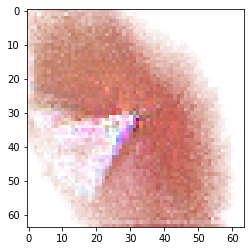

Epoch 602, Loss: 8.706216812133789
Epoch 603, Loss: 8.284899711608887
Epoch 604, Loss: 8.570686340332031
Epoch 605, Loss: 7.769857883453369
Epoch 606, Loss: 8.405105590820312
Epoch 607, Loss: 7.591892242431641
Epoch 608, Loss: 8.542302131652832
Epoch 609, Loss: 8.971940040588379
Epoch 610, Loss: 10.226944923400879
Epoch 611, Loss: 8.42546558380127
Epoch 612, Loss: 8.076692581176758
Epoch 613, Loss: 8.356212615966797
Epoch 614, Loss: 8.565510749816895
Epoch 615, Loss: 9.571819305419922
Epoch 616, Loss: 11.438231468200684
Epoch 617, Loss: 9.415279388427734
Epoch 618, Loss: 12.786417961120605
Epoch 619, Loss: 9.329002380371094
Epoch 620, Loss: 8.958760261535645
Epoch 621, Loss: 11.209047317504883
Epoch 622, Loss: 9.695630073547363
Epoch 623, Loss: 9.728228569030762
Epoch 624, Loss: 9.31373119354248
Epoch 625, Loss: 9.088388442993164


Epoch 626, Loss: 8.676743507385254


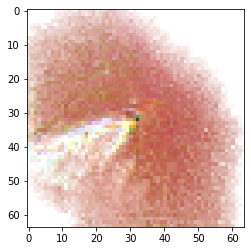

Epoch 627, Loss: 8.417488098144531
Epoch 628, Loss: 9.115104675292969
Epoch 629, Loss: 8.1405029296875
Epoch 630, Loss: 8.612436294555664
Epoch 631, Loss: 8.292724609375
Epoch 632, Loss: 8.763928413391113
Epoch 633, Loss: 10.024968147277832
Epoch 634, Loss: 8.290977478027344
Epoch 635, Loss: 8.01600456237793
Epoch 636, Loss: 8.941547393798828
Epoch 637, Loss: 9.359978675842285
Epoch 638, Loss: 8.377659797668457
Epoch 639, Loss: 9.101507186889648
Epoch 640, Loss: 8.961750984191895
Epoch 641, Loss: 8.68021011352539
Epoch 642, Loss: 10.412018775939941
Epoch 643, Loss: 8.746431350708008
Epoch 644, Loss: 8.690348625183105
Epoch 645, Loss: 8.218405723571777
Epoch 646, Loss: 11.910303115844727
Epoch 647, Loss: 9.246262550354004
Epoch 648, Loss: 8.910974502563477
Epoch 649, Loss: 8.338977813720703
Epoch 650, Loss: 8.889434814453125


Epoch 651, Loss: 8.196549415588379


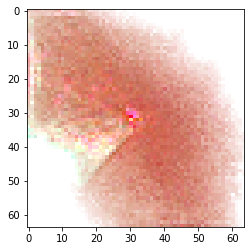

Epoch 652, Loss: 9.35988998413086
Epoch 653, Loss: 8.892878532409668
Epoch 654, Loss: 9.119135856628418
Epoch 655, Loss: 8.543456077575684
Epoch 656, Loss: 9.491847038269043
Epoch 657, Loss: 8.967211723327637
Epoch 658, Loss: 8.77908992767334
Epoch 659, Loss: 8.172986030578613
Epoch 660, Loss: 8.121696472167969
Epoch 661, Loss: 8.43506908416748
Epoch 662, Loss: 9.875969886779785
Epoch 663, Loss: 8.356618881225586
Epoch 664, Loss: 8.103324890136719
Epoch 665, Loss: 8.240594863891602
Epoch 666, Loss: 8.461475372314453
Epoch 667, Loss: 8.519096374511719
Epoch 668, Loss: 9.215958595275879
Epoch 669, Loss: 8.296832084655762
Epoch 670, Loss: 8.16229248046875
Epoch 671, Loss: 8.546489715576172
Epoch 672, Loss: 10.74785041809082
Epoch 673, Loss: 10.348527908325195
Epoch 674, Loss: 7.792881011962891
Epoch 675, Loss: 8.131056785583496


Epoch 676, Loss: 8.050910949707031


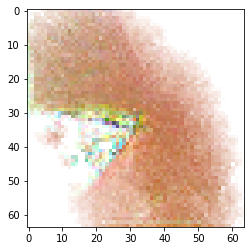

Epoch 677, Loss: 7.930373191833496
Epoch 678, Loss: 8.418890953063965
Epoch 679, Loss: 7.528021812438965
Epoch 680, Loss: 8.260429382324219
Epoch 681, Loss: 8.255064010620117
Epoch 682, Loss: 8.386702537536621
Epoch 683, Loss: 8.112553596496582
Epoch 684, Loss: 8.31639575958252
Epoch 685, Loss: 8.053790092468262
Epoch 686, Loss: 10.500323295593262
Epoch 687, Loss: 7.995316505432129
Epoch 688, Loss: 8.253787994384766
Epoch 689, Loss: 8.19141960144043
Epoch 690, Loss: 8.466381072998047
Epoch 691, Loss: 9.674093246459961
Epoch 692, Loss: 7.76057767868042
Epoch 693, Loss: 8.362275123596191
Epoch 694, Loss: 8.38583755493164
Epoch 695, Loss: 8.568460464477539
Epoch 696, Loss: 7.936018943786621
Epoch 697, Loss: 7.866476535797119
Epoch 698, Loss: 8.318497657775879
Epoch 699, Loss: 9.139616012573242
Epoch 700, Loss: 11.96796703338623


Epoch 701, Loss: 9.09142017364502


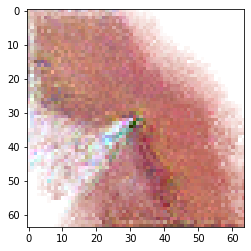

Epoch 702, Loss: 9.03261947631836
Epoch 703, Loss: 8.966038703918457
Epoch 704, Loss: 8.227113723754883
Epoch 705, Loss: 8.649947166442871
Epoch 706, Loss: 8.538518905639648
Epoch 707, Loss: 7.981072425842285
Epoch 708, Loss: 8.14205551147461
Epoch 709, Loss: 8.534290313720703
Epoch 710, Loss: 8.027341842651367
Epoch 711, Loss: 7.868602752685547
Epoch 712, Loss: 9.819929122924805
Epoch 713, Loss: 8.620665550231934
Epoch 714, Loss: 8.08393383026123
Epoch 715, Loss: 8.53325080871582
Epoch 716, Loss: 8.590620994567871
Epoch 717, Loss: 10.075226783752441
Epoch 718, Loss: 9.62342357635498
Epoch 719, Loss: 13.992257118225098
Epoch 720, Loss: 10.83614730834961
Epoch 721, Loss: 17.049468994140625
Epoch 722, Loss: 8.72055721282959
Epoch 723, Loss: 9.56249713897705
Epoch 724, Loss: 9.201476097106934
Epoch 725, Loss: 8.610424041748047


Epoch 726, Loss: 9.106344223022461


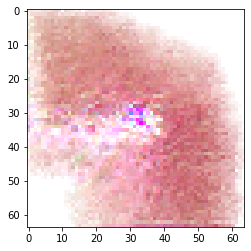

Epoch 727, Loss: 9.33651065826416
Epoch 728, Loss: 9.374138832092285
Epoch 729, Loss: 8.540911674499512
Epoch 730, Loss: 8.045405387878418
Epoch 731, Loss: 8.894851684570312
Epoch 732, Loss: 7.887548923492432
Epoch 733, Loss: 8.161537170410156
Epoch 734, Loss: 9.144549369812012
Epoch 735, Loss: 8.381525993347168
Epoch 736, Loss: 7.933077335357666
Epoch 737, Loss: 8.159029006958008
Epoch 738, Loss: 9.093511581420898
Epoch 739, Loss: 8.059141159057617
Epoch 740, Loss: 8.256905555725098
Epoch 741, Loss: 8.806763648986816
Epoch 742, Loss: 7.999689102172852
Epoch 743, Loss: 8.919966697692871
Epoch 744, Loss: 8.256024360656738
Epoch 745, Loss: 9.484228134155273
Epoch 746, Loss: 8.908134460449219
Epoch 747, Loss: 8.381964683532715
Epoch 748, Loss: 8.148515701293945
Epoch 749, Loss: 9.33234691619873
Epoch 750, Loss: 7.934426307678223


Epoch 751, Loss: 7.460468292236328


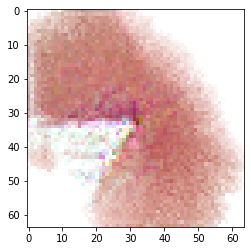

Epoch 752, Loss: 8.585579872131348
Epoch 753, Loss: 8.262904167175293
Epoch 754, Loss: 8.279746055603027
Epoch 755, Loss: 9.127724647521973
Epoch 756, Loss: 8.689987182617188
Epoch 757, Loss: 8.26859188079834
Epoch 758, Loss: 7.820440769195557
Epoch 759, Loss: 8.103591918945312
Epoch 760, Loss: 9.369555473327637
Epoch 761, Loss: 8.07068157196045
Epoch 762, Loss: 8.483360290527344
Epoch 763, Loss: 8.328986167907715
Epoch 764, Loss: 7.665228843688965
Epoch 765, Loss: 7.516054153442383
Epoch 766, Loss: 8.473828315734863
Epoch 767, Loss: 7.826746940612793
Epoch 768, Loss: 8.808270454406738
Epoch 769, Loss: 8.02907943725586
Epoch 770, Loss: 8.054706573486328
Epoch 771, Loss: 7.984846115112305
Epoch 772, Loss: 8.951371192932129
Epoch 773, Loss: 8.852887153625488
Epoch 774, Loss: 8.633962631225586
Epoch 775, Loss: 8.313117027282715


Epoch 776, Loss: 8.220013618469238


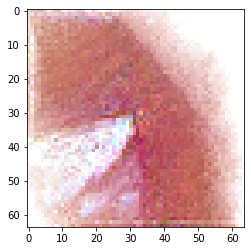

Epoch 777, Loss: 7.684937953948975
Epoch 778, Loss: 7.479225158691406
Epoch 779, Loss: 8.110844612121582
Epoch 780, Loss: 8.422388076782227
Epoch 781, Loss: 8.43768310546875
Epoch 782, Loss: 9.279470443725586
Epoch 783, Loss: 8.553363800048828
Epoch 784, Loss: 10.127042770385742
Epoch 785, Loss: 7.529971122741699
Epoch 786, Loss: 8.363616943359375
Epoch 787, Loss: 8.248181343078613
Epoch 788, Loss: 7.905860900878906
Epoch 789, Loss: 7.733645439147949
Epoch 790, Loss: 7.850652694702148
Epoch 791, Loss: 7.870355129241943
Epoch 792, Loss: 7.652428150177002
Epoch 793, Loss: 7.7536540031433105
Epoch 794, Loss: 7.620970249176025
Epoch 795, Loss: 7.56842565536499
Epoch 796, Loss: 7.21137809753418
Epoch 797, Loss: 7.622097492218018
Epoch 798, Loss: 7.472888946533203
Epoch 799, Loss: 9.08651351928711
Epoch 800, Loss: 8.4946870803833


Epoch 801, Loss: 8.093375205993652


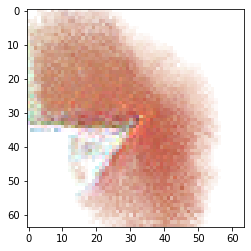

Epoch 802, Loss: 7.972735404968262
Epoch 803, Loss: 8.360701560974121
Epoch 804, Loss: 8.148826599121094
Epoch 805, Loss: 8.24329662322998
Epoch 806, Loss: 7.7937469482421875
Epoch 807, Loss: 8.063559532165527
Epoch 808, Loss: 8.128337860107422
Epoch 809, Loss: 8.550150871276855
Epoch 810, Loss: 8.968372344970703
Epoch 811, Loss: 7.8834428787231445
Epoch 812, Loss: 9.183109283447266
Epoch 813, Loss: 8.064509391784668
Epoch 814, Loss: 7.755506992340088
Epoch 815, Loss: 7.321591854095459
Epoch 816, Loss: 7.626699447631836
Epoch 817, Loss: 7.678529739379883
Epoch 818, Loss: 8.184549331665039
Epoch 819, Loss: 8.683152198791504
Epoch 820, Loss: 7.9588303565979
Epoch 821, Loss: 7.769499778747559
Epoch 822, Loss: 8.32327651977539
Epoch 823, Loss: 7.921496868133545
Epoch 824, Loss: 9.654086112976074
Epoch 825, Loss: 8.414678573608398


Epoch 826, Loss: 10.36046028137207


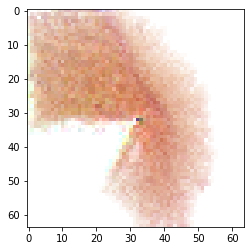

Epoch 827, Loss: 10.219934463500977
Epoch 828, Loss: 9.285057067871094
Epoch 829, Loss: 7.726655006408691
Epoch 830, Loss: 8.596694946289062
Epoch 831, Loss: 7.941591739654541
Epoch 832, Loss: 7.665256977081299
Epoch 833, Loss: 9.4332857131958
Epoch 834, Loss: 9.529073715209961
Epoch 835, Loss: 9.283721923828125
Epoch 836, Loss: 9.062315940856934
Epoch 837, Loss: 9.626418113708496
Epoch 838, Loss: 10.053414344787598
Epoch 839, Loss: 10.486921310424805
Epoch 840, Loss: 9.947260856628418
Epoch 841, Loss: 9.27869701385498
Epoch 842, Loss: 9.303972244262695
Epoch 843, Loss: 7.8658037185668945
Epoch 844, Loss: 8.210785865783691
Epoch 845, Loss: 8.659363746643066
Epoch 846, Loss: 8.347309112548828
Epoch 847, Loss: 7.939226150512695
Epoch 848, Loss: 7.735941410064697
Epoch 849, Loss: 7.908901691436768
Epoch 850, Loss: 8.22470474243164


Epoch 851, Loss: 8.287749290466309


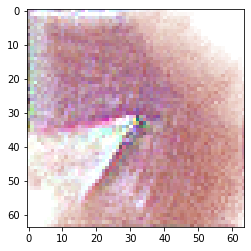

Epoch 852, Loss: 7.946335315704346
Epoch 853, Loss: 7.818921089172363
Epoch 854, Loss: 8.050532341003418
Epoch 855, Loss: 8.419266700744629
Epoch 856, Loss: 7.601086139678955
Epoch 857, Loss: 7.746548175811768
Epoch 858, Loss: 7.897591590881348
Epoch 859, Loss: 7.801855564117432
Epoch 860, Loss: 7.54344367980957
Epoch 861, Loss: 7.682868003845215
Epoch 862, Loss: 7.606966972351074
Epoch 863, Loss: 7.569935321807861
Epoch 864, Loss: 7.168213367462158
Epoch 865, Loss: 7.227792739868164
Epoch 866, Loss: 7.708435535430908
Epoch 867, Loss: 7.452234745025635
Epoch 868, Loss: 7.6882405281066895
Epoch 869, Loss: 7.79862117767334
Epoch 870, Loss: 7.581974506378174
Epoch 871, Loss: 7.77055549621582
Epoch 872, Loss: 8.00261402130127
Epoch 873, Loss: 8.101175308227539
Epoch 874, Loss: 7.3996782302856445
Epoch 875, Loss: 7.706978797912598


Epoch 876, Loss: 7.829894065856934


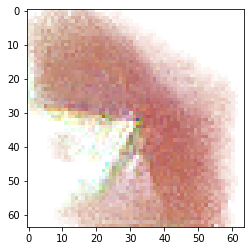

Epoch 877, Loss: 8.24337387084961
Epoch 878, Loss: 7.483684062957764
Epoch 879, Loss: 7.822281837463379
Epoch 880, Loss: 7.601567268371582
Epoch 881, Loss: 7.60048770904541
Epoch 882, Loss: 7.584417819976807
Epoch 883, Loss: 7.397838115692139
Epoch 884, Loss: 7.476091384887695
Epoch 885, Loss: 7.474329948425293
Epoch 886, Loss: 7.356473922729492
Epoch 887, Loss: 7.660833835601807
Epoch 888, Loss: 7.061238765716553
Epoch 889, Loss: 7.307443618774414
Epoch 890, Loss: 6.931154251098633
Epoch 891, Loss: 6.910885334014893
Epoch 892, Loss: 7.821242332458496
Epoch 893, Loss: 7.403071880340576
Epoch 894, Loss: 7.927884101867676
Epoch 895, Loss: 8.302607536315918
Epoch 896, Loss: 8.548782348632812
Epoch 897, Loss: 7.657906532287598
Epoch 898, Loss: 8.068883895874023
Epoch 899, Loss: 7.526833534240723
Epoch 900, Loss: 8.063469886779785


Epoch 901, Loss: 7.487091541290283


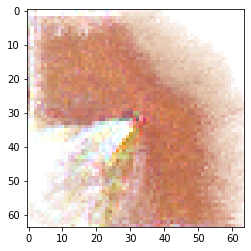

Epoch 902, Loss: 7.3211894035339355
Epoch 903, Loss: 7.913092613220215
Epoch 904, Loss: 7.830960273742676
Epoch 905, Loss: 7.897998332977295
Epoch 906, Loss: 7.741776943206787
Epoch 907, Loss: 8.371979713439941
Epoch 908, Loss: 8.506229400634766
Epoch 909, Loss: 8.085182189941406
Epoch 910, Loss: 8.199135780334473
Epoch 911, Loss: 7.823182582855225
Epoch 912, Loss: 7.95731258392334
Epoch 913, Loss: 8.067658424377441
Epoch 914, Loss: 8.22965145111084
Epoch 915, Loss: 7.69721794128418
Epoch 916, Loss: 7.9351372718811035
Epoch 917, Loss: 8.841376304626465
Epoch 918, Loss: 7.626595497131348
Epoch 919, Loss: 8.201362609863281
Epoch 920, Loss: 7.412078857421875
Epoch 921, Loss: 7.646457672119141
Epoch 922, Loss: 8.52367877960205
Epoch 923, Loss: 9.051862716674805
Epoch 924, Loss: 8.186373710632324
Epoch 925, Loss: 8.00002670288086


Epoch 926, Loss: 8.16687297821045


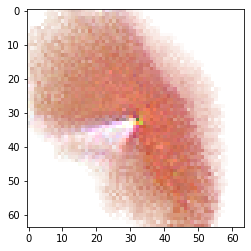

Epoch 927, Loss: 7.728514671325684
Epoch 928, Loss: 8.78750228881836
Epoch 929, Loss: 8.331372261047363
Epoch 930, Loss: 7.630184173583984
Epoch 931, Loss: 7.771860122680664
Epoch 932, Loss: 7.641336441040039
Epoch 933, Loss: 8.164900779724121
Epoch 934, Loss: 7.3440842628479
Epoch 935, Loss: 7.789410591125488
Epoch 936, Loss: 7.201672554016113
Epoch 937, Loss: 7.421720027923584
Epoch 938, Loss: 8.63746452331543
Epoch 939, Loss: 7.314159870147705
Epoch 940, Loss: 7.461155414581299
Epoch 941, Loss: 7.118219375610352
Epoch 942, Loss: 7.219415187835693
Epoch 943, Loss: 7.967072010040283
Epoch 944, Loss: 9.26473617553711
Epoch 945, Loss: 9.067092895507812
Epoch 946, Loss: 7.407966136932373
Epoch 947, Loss: 7.435390472412109
Epoch 948, Loss: 7.577517509460449
Epoch 949, Loss: 8.226512908935547
Epoch 950, Loss: 8.950723648071289


Epoch 951, Loss: 8.958463668823242


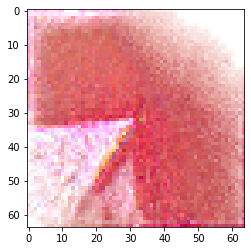

Epoch 952, Loss: 8.236388206481934
Epoch 953, Loss: 7.885013580322266
Epoch 954, Loss: 7.630092620849609
Epoch 955, Loss: 7.437671184539795
Epoch 956, Loss: 7.3430657386779785
Epoch 957, Loss: 7.333184719085693
Epoch 958, Loss: 8.02462100982666
Epoch 959, Loss: 7.5470476150512695
Epoch 960, Loss: 7.371462345123291
Epoch 961, Loss: 7.217608451843262
Epoch 962, Loss: 7.642081260681152
Epoch 963, Loss: 7.639517784118652
Epoch 964, Loss: 7.730003356933594
Epoch 965, Loss: 10.348770141601562
Epoch 966, Loss: 7.546877861022949
Epoch 967, Loss: 10.643025398254395
Epoch 968, Loss: 12.35074234008789
Epoch 969, Loss: 8.128426551818848
Epoch 970, Loss: 8.888314247131348
Epoch 971, Loss: 8.973746299743652
Epoch 972, Loss: 7.38226318359375
Epoch 973, Loss: 8.155350685119629
Epoch 974, Loss: 7.27003288269043
Epoch 975, Loss: 7.359798431396484


Epoch 976, Loss: 8.001794815063477


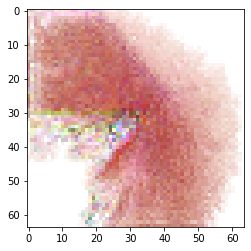

Epoch 977, Loss: 7.60805606842041
Epoch 978, Loss: 7.663712024688721
Epoch 979, Loss: 8.750946044921875
Epoch 980, Loss: 7.568988800048828
Epoch 981, Loss: 8.06258773803711
Epoch 982, Loss: 7.601430892944336
Epoch 983, Loss: 7.632030487060547
Epoch 984, Loss: 7.405062198638916
Epoch 985, Loss: 7.448764324188232
Epoch 986, Loss: 7.013208389282227
Epoch 987, Loss: 8.404634475708008
Epoch 988, Loss: 8.11656665802002
Epoch 989, Loss: 7.3944926261901855
Epoch 990, Loss: 7.565228462219238
Epoch 991, Loss: 7.223538398742676
Epoch 992, Loss: 7.658001899719238
Epoch 993, Loss: 7.877951622009277
Epoch 994, Loss: 7.2462334632873535
Epoch 995, Loss: 7.7391886711120605
Epoch 996, Loss: 6.919546604156494
Epoch 997, Loss: 8.012767791748047
Epoch 998, Loss: 7.714983940124512
Epoch 999, Loss: 6.7861328125
Epoch 1000, Loss: 7.145672798156738


Epoch 1001, Loss: 7.671012878417969


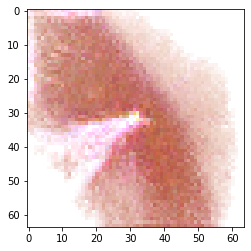

Epoch 1002, Loss: 7.334222793579102
Epoch 1003, Loss: 6.856206893920898
Epoch 1004, Loss: 7.726276874542236
Epoch 1005, Loss: 6.861315727233887
Epoch 1006, Loss: 6.881054401397705
Epoch 1007, Loss: 7.884369850158691
Epoch 1008, Loss: 6.538346290588379
Epoch 1009, Loss: 7.8513054847717285
Epoch 1010, Loss: 7.279182434082031
Epoch 1011, Loss: 6.712952136993408
Epoch 1012, Loss: 6.968563079833984
Epoch 1013, Loss: 6.602197647094727
Epoch 1014, Loss: 6.448760032653809
Epoch 1015, Loss: 6.2113261222839355
Epoch 1016, Loss: 7.277476787567139
Epoch 1017, Loss: 7.187445640563965
Epoch 1018, Loss: 7.027530670166016
Epoch 1019, Loss: 5.903667449951172
Epoch 1020, Loss: 6.932802677154541
Epoch 1021, Loss: 6.345069408416748
Epoch 1022, Loss: 8.59251594543457
Epoch 1023, Loss: 8.098858833312988
Epoch 1024, Loss: 7.152610778808594
Epoch 1025, Loss: 7.0406622886657715


Epoch 1026, Loss: 6.778506755828857


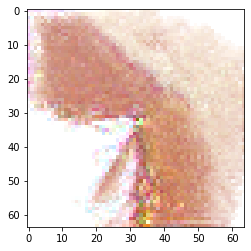

Epoch 1027, Loss: 7.079592227935791
Epoch 1028, Loss: 7.165060997009277
Epoch 1029, Loss: 7.141468048095703
Epoch 1030, Loss: 6.900837421417236
Epoch 1031, Loss: 6.22136926651001
Epoch 1032, Loss: 7.007793426513672
Epoch 1033, Loss: 6.651158809661865
Epoch 1034, Loss: 6.620102405548096
Epoch 1035, Loss: 5.8689866065979
Epoch 1036, Loss: 5.735266208648682
Epoch 1037, Loss: 6.474749565124512
Epoch 1038, Loss: 8.419569969177246
Epoch 1039, Loss: 5.8795952796936035
Epoch 1040, Loss: 6.633354663848877
Epoch 1041, Loss: 6.216933727264404
Epoch 1042, Loss: 6.304470539093018
Epoch 1043, Loss: 6.8764166831970215
Epoch 1044, Loss: 7.814487934112549
Epoch 1045, Loss: 6.241457939147949
Epoch 1046, Loss: 6.380851745605469
Epoch 1047, Loss: 6.139054298400879
Epoch 1048, Loss: 6.1614089012146
Epoch 1049, Loss: 6.496086597442627
Epoch 1050, Loss: 6.518317222595215


Epoch 1051, Loss: 7.374817848205566


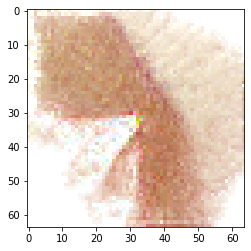

Epoch 1052, Loss: 5.928823947906494
Epoch 1053, Loss: 7.124366760253906
Epoch 1054, Loss: 7.117988109588623
Epoch 1055, Loss: 7.200564384460449
Epoch 1056, Loss: 6.571826934814453
Epoch 1057, Loss: 6.782014846801758
Epoch 1058, Loss: 7.464314937591553
Epoch 1059, Loss: 7.493269443511963
Epoch 1060, Loss: 6.5888590812683105
Epoch 1061, Loss: 7.057518005371094
Epoch 1062, Loss: 7.533450603485107
Epoch 1063, Loss: 5.95791482925415
Epoch 1064, Loss: 6.3459367752075195
Epoch 1065, Loss: 6.729981422424316
Epoch 1066, Loss: 6.287595748901367
Epoch 1067, Loss: 6.146746635437012
Epoch 1068, Loss: 6.742448329925537
Epoch 1069, Loss: 5.689323902130127
Epoch 1070, Loss: 5.842195510864258
Epoch 1071, Loss: 7.390336513519287
Epoch 1072, Loss: 6.807589530944824
Epoch 1073, Loss: 7.662407398223877
Epoch 1074, Loss: 6.87587833404541
Epoch 1075, Loss: 6.442619323730469


Epoch 1076, Loss: 7.911250591278076


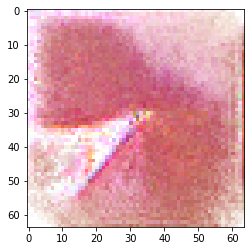

Epoch 1077, Loss: 6.244725227355957
Epoch 1078, Loss: 6.172987937927246
Epoch 1079, Loss: 6.335894584655762
Epoch 1080, Loss: 7.612065315246582
Epoch 1081, Loss: 6.7161431312561035
Epoch 1082, Loss: 6.095285892486572
Epoch 1083, Loss: 7.367616653442383
Epoch 1084, Loss: 6.444030284881592
Epoch 1085, Loss: 6.456360340118408
Epoch 1086, Loss: 5.855987548828125
Epoch 1087, Loss: 5.7768964767456055
Epoch 1088, Loss: 6.283602714538574
Epoch 1089, Loss: 5.8324971199035645
Epoch 1090, Loss: 5.4195027351379395
Epoch 1091, Loss: 5.616306304931641
Epoch 1092, Loss: 8.421058654785156
Epoch 1093, Loss: 5.448890686035156
Epoch 1094, Loss: 6.717103004455566
Epoch 1095, Loss: 7.967249393463135
Epoch 1096, Loss: 6.604433059692383
Epoch 1097, Loss: 6.108982086181641
Epoch 1098, Loss: 6.361332416534424
Epoch 1099, Loss: 6.622937202453613
Epoch 1100, Loss: 6.559009075164795


Epoch 1101, Loss: 5.992061614990234


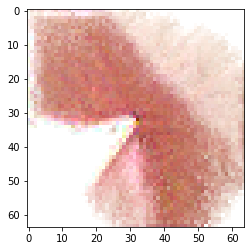

Epoch 1102, Loss: 6.814862251281738
Epoch 1103, Loss: 6.186054706573486
Epoch 1104, Loss: 6.711989402770996
Epoch 1105, Loss: 5.293899059295654
Epoch 1106, Loss: 6.699019432067871
Epoch 1107, Loss: 5.371552467346191
Epoch 1108, Loss: 5.383224010467529
Epoch 1109, Loss: 5.789532661437988
Epoch 1110, Loss: 7.273123264312744
Epoch 1111, Loss: 5.456356525421143
Epoch 1112, Loss: 5.521377086639404
Epoch 1113, Loss: 5.457730770111084
Epoch 1114, Loss: 6.695589542388916
Epoch 1115, Loss: 5.882143497467041
Epoch 1116, Loss: 6.155272960662842
Epoch 1117, Loss: 5.628885269165039
Epoch 1118, Loss: 5.470366477966309
Epoch 1119, Loss: 6.313634872436523
Epoch 1120, Loss: 6.248128890991211
Epoch 1121, Loss: 5.3588433265686035
Epoch 1122, Loss: 5.509119510650635
Epoch 1123, Loss: 6.4756879806518555
Epoch 1124, Loss: 5.946805477142334
Epoch 1125, Loss: 6.006677627563477


Epoch 1126, Loss: 5.536026477813721


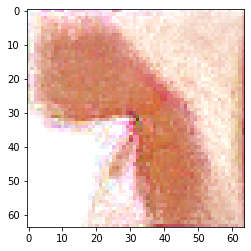

Epoch 1127, Loss: 5.979362964630127
Epoch 1128, Loss: 5.109391689300537
Epoch 1129, Loss: 5.965952396392822
Epoch 1130, Loss: 5.340847969055176
Epoch 1131, Loss: 4.952234268188477
Epoch 1132, Loss: 5.27531099319458
Epoch 1133, Loss: 5.442385196685791
Epoch 1134, Loss: 6.230553150177002
Epoch 1135, Loss: 7.499183177947998
Epoch 1136, Loss: 5.380233287811279
Epoch 1137, Loss: 5.756801605224609
Epoch 1138, Loss: 5.555345058441162
Epoch 1139, Loss: 8.327957153320312
Epoch 1140, Loss: 5.140446662902832
Epoch 1141, Loss: 5.055884838104248
Epoch 1142, Loss: 6.994114875793457
Epoch 1143, Loss: 5.747314929962158
Epoch 1144, Loss: 6.620342254638672
Epoch 1145, Loss: 6.781023979187012
Epoch 1146, Loss: 5.453003406524658
Epoch 1147, Loss: 5.823091983795166
Epoch 1148, Loss: 5.55073356628418
Epoch 1149, Loss: 6.094604015350342
Epoch 1150, Loss: 5.784956455230713


Epoch 1151, Loss: 5.932858467102051


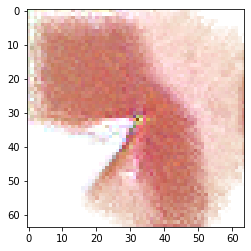

Epoch 1152, Loss: 7.639984130859375
Epoch 1153, Loss: 5.3310441970825195
Epoch 1154, Loss: 6.216144561767578
Epoch 1155, Loss: 5.4837422370910645
Epoch 1156, Loss: 6.4165263175964355
Epoch 1157, Loss: 6.087515354156494
Epoch 1158, Loss: 5.542142868041992
Epoch 1159, Loss: 5.608725547790527
Epoch 1160, Loss: 5.460999011993408
Epoch 1161, Loss: 6.030943870544434
Epoch 1162, Loss: 5.4433441162109375
Epoch 1163, Loss: 5.6973419189453125
Epoch 1164, Loss: 5.712960720062256
Epoch 1165, Loss: 5.316565036773682
Epoch 1166, Loss: 5.919867515563965
Epoch 1167, Loss: 5.878767013549805
Epoch 1168, Loss: 7.0115509033203125
Epoch 1169, Loss: 6.271016597747803
Epoch 1170, Loss: 6.923365592956543
Epoch 1171, Loss: 6.938687801361084
Epoch 1172, Loss: 6.691054344177246
Epoch 1173, Loss: 6.373568058013916
Epoch 1174, Loss: 5.719947338104248
Epoch 1175, Loss: 6.267771244049072


Epoch 1176, Loss: 7.6021270751953125


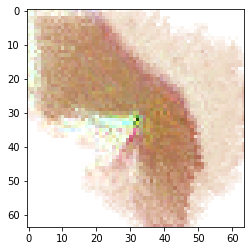

Epoch 1177, Loss: 7.7247419357299805
Epoch 1178, Loss: 7.143160820007324
Epoch 1179, Loss: 6.150875091552734
Epoch 1180, Loss: 5.450897693634033
Epoch 1181, Loss: 5.97140645980835
Epoch 1182, Loss: 6.497433662414551
Epoch 1183, Loss: 5.926597595214844
Epoch 1184, Loss: 5.3717265129089355
Epoch 1185, Loss: 5.499946594238281
Epoch 1186, Loss: 5.701740264892578
Epoch 1187, Loss: 5.516998291015625
Epoch 1188, Loss: 6.121737480163574
Epoch 1189, Loss: 5.343776702880859
Epoch 1190, Loss: 5.816075801849365
Epoch 1191, Loss: 6.893692970275879
Epoch 1192, Loss: 5.829150199890137
Epoch 1193, Loss: 5.557980537414551
Epoch 1194, Loss: 5.641422271728516
Epoch 1195, Loss: 6.749679088592529
Epoch 1196, Loss: 5.274041652679443
Epoch 1197, Loss: 5.112358093261719
Epoch 1198, Loss: 6.233304977416992
Epoch 1199, Loss: 5.642694473266602
Epoch 1200, Loss: 5.912826061248779


Epoch 1201, Loss: 5.417715549468994


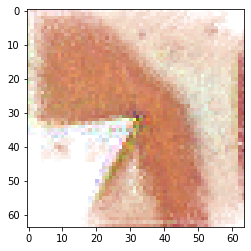

Epoch 1202, Loss: 4.898499011993408
Epoch 1203, Loss: 5.522745132446289
Epoch 1204, Loss: 5.867372512817383
Epoch 1205, Loss: 7.134694576263428
Epoch 1206, Loss: 5.879521369934082
Epoch 1207, Loss: 5.825345039367676
Epoch 1208, Loss: 6.715799331665039
Epoch 1209, Loss: 5.2736735343933105
Epoch 1210, Loss: 5.7759013175964355
Epoch 1211, Loss: 7.85698127746582
Epoch 1212, Loss: 6.221071720123291
Epoch 1213, Loss: 6.264065265655518
Epoch 1214, Loss: 6.296670436859131
Epoch 1215, Loss: 5.7196760177612305
Epoch 1216, Loss: 5.50038480758667
Epoch 1217, Loss: 5.379142761230469
Epoch 1218, Loss: 5.429349899291992
Epoch 1219, Loss: 6.122618675231934
Epoch 1220, Loss: 5.366518497467041
Epoch 1221, Loss: 5.288697719573975
Epoch 1222, Loss: 5.6986823081970215
Epoch 1223, Loss: 8.001611709594727
Epoch 1224, Loss: 5.1700544357299805
Epoch 1225, Loss: 6.249123573303223


Epoch 1226, Loss: 5.243742942810059


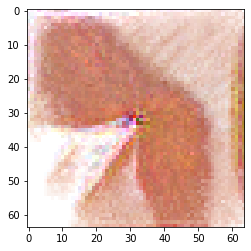

Epoch 1227, Loss: 4.717021942138672
Epoch 1228, Loss: 5.117364406585693
Epoch 1229, Loss: 4.653555393218994
Epoch 1230, Loss: 4.880593776702881
Epoch 1231, Loss: 7.138707637786865
Epoch 1232, Loss: 5.500800132751465
Epoch 1233, Loss: 5.787538051605225
Epoch 1234, Loss: 5.915971755981445
Epoch 1235, Loss: 5.834334373474121
Epoch 1236, Loss: 6.283473014831543
Epoch 1237, Loss: 5.8266072273254395
Epoch 1238, Loss: 6.449323654174805
Epoch 1239, Loss: 6.493694305419922
Epoch 1240, Loss: 5.862996578216553
Epoch 1241, Loss: 5.264681339263916
Epoch 1242, Loss: 5.665746212005615
Epoch 1243, Loss: 5.119624137878418
Epoch 1244, Loss: 5.706088066101074
Epoch 1245, Loss: 6.200158596038818
Epoch 1246, Loss: 5.732985496520996
Epoch 1247, Loss: 5.462244987487793
Epoch 1248, Loss: 5.785688400268555
Epoch 1249, Loss: 5.053762912750244
Epoch 1250, Loss: 6.348569869995117


Epoch 1251, Loss: 4.8833088874816895


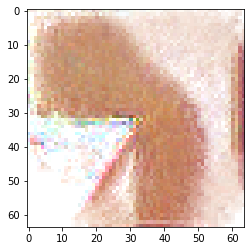

Epoch 1252, Loss: 4.868013858795166
Epoch 1253, Loss: 5.087937831878662
Epoch 1254, Loss: 6.159212589263916
Epoch 1255, Loss: 4.984525680541992
Epoch 1256, Loss: 6.384771347045898
Epoch 1257, Loss: 5.940269470214844
Epoch 1258, Loss: 7.233647346496582
Epoch 1259, Loss: 7.296975135803223
Epoch 1260, Loss: 6.00186014175415
Epoch 1261, Loss: 6.103565692901611
Epoch 1262, Loss: 6.207705497741699
Epoch 1263, Loss: 5.697375297546387
Epoch 1264, Loss: 6.3884735107421875
Epoch 1265, Loss: 6.585735321044922
Epoch 1266, Loss: 5.559146404266357
Epoch 1267, Loss: 6.341629981994629
Epoch 1268, Loss: 5.96835994720459
Epoch 1269, Loss: 5.70253324508667
Epoch 1270, Loss: 5.829963684082031
Epoch 1271, Loss: 5.56306266784668
Epoch 1272, Loss: 7.024129390716553
Epoch 1273, Loss: 5.4880805015563965
Epoch 1274, Loss: 7.03223180770874
Epoch 1275, Loss: 6.925995826721191


Epoch 1276, Loss: 5.364146709442139


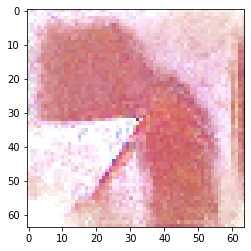

Epoch 1277, Loss: 6.840087413787842
Epoch 1278, Loss: 6.056159496307373
Epoch 1279, Loss: 7.453794002532959
Epoch 1280, Loss: 6.3518195152282715
Epoch 1281, Loss: 6.542514324188232
Epoch 1282, Loss: 5.602988243103027
Epoch 1283, Loss: 5.298741340637207
Epoch 1284, Loss: 4.862284183502197
Epoch 1285, Loss: 6.299890041351318
Epoch 1286, Loss: 7.39768648147583
Epoch 1287, Loss: 5.66933536529541
Epoch 1288, Loss: 5.8623270988464355
Epoch 1289, Loss: 6.190340995788574
Epoch 1290, Loss: 5.848798751831055
Epoch 1291, Loss: 5.860926151275635
Epoch 1292, Loss: 5.654874801635742
Epoch 1293, Loss: 5.509929180145264
Epoch 1294, Loss: 6.014708518981934
Epoch 1295, Loss: 5.981782913208008
Epoch 1296, Loss: 5.539475440979004
Epoch 1297, Loss: 5.632294178009033
Epoch 1298, Loss: 7.138566017150879
Epoch 1299, Loss: 7.5012311935424805
Epoch 1300, Loss: 9.259178161621094


Epoch 1301, Loss: 10.62960433959961


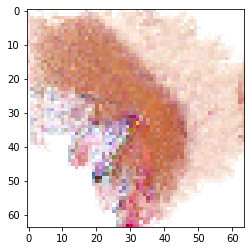

Epoch 1302, Loss: 6.055571556091309
Epoch 1303, Loss: 5.951742649078369
Epoch 1304, Loss: 7.5086517333984375
Epoch 1305, Loss: 7.03743314743042
Epoch 1306, Loss: 6.363590240478516
Epoch 1307, Loss: 5.96390962600708
Epoch 1308, Loss: 8.240094184875488
Epoch 1309, Loss: 6.021521091461182
Epoch 1310, Loss: 5.86126708984375
Epoch 1311, Loss: 5.76426887512207
Epoch 1312, Loss: 5.237117290496826
Epoch 1313, Loss: 7.3417253494262695
Epoch 1314, Loss: 6.531018257141113
Epoch 1315, Loss: 5.653003692626953
Epoch 1316, Loss: 5.101431369781494
Epoch 1317, Loss: 5.052243709564209
Epoch 1318, Loss: 5.467845439910889
Epoch 1319, Loss: 5.341765880584717
Epoch 1320, Loss: 6.005133628845215
Epoch 1321, Loss: 6.195760726928711
Epoch 1322, Loss: 5.307388782501221
Epoch 1323, Loss: 5.143793106079102
Epoch 1324, Loss: 6.160899639129639
Epoch 1325, Loss: 5.829257488250732


Epoch 1326, Loss: 5.828612327575684


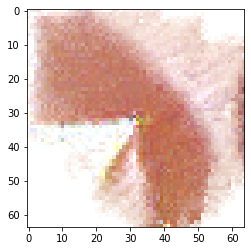

Epoch 1327, Loss: 6.194915771484375
Epoch 1328, Loss: 5.690839767456055
Epoch 1329, Loss: 6.663980484008789
Epoch 1330, Loss: 5.684747695922852
Epoch 1331, Loss: 5.7710957527160645
Epoch 1332, Loss: 5.1815290451049805
Epoch 1333, Loss: 6.360163688659668
Epoch 1334, Loss: 5.0252580642700195
Epoch 1335, Loss: 5.981953144073486
Epoch 1336, Loss: 4.992976665496826
Epoch 1337, Loss: 5.990728378295898
Epoch 1338, Loss: 5.861247539520264
Epoch 1339, Loss: 5.014593601226807
Epoch 1340, Loss: 4.724143028259277
Epoch 1341, Loss: 4.697751998901367
Epoch 1342, Loss: 5.2179694175720215
Epoch 1343, Loss: 5.442005634307861
Epoch 1344, Loss: 4.904078483581543
Epoch 1345, Loss: 5.255618095397949
Epoch 1346, Loss: 6.427884101867676
Epoch 1347, Loss: 5.270337104797363
Epoch 1348, Loss: 5.0832295417785645
Epoch 1349, Loss: 4.858893394470215
Epoch 1350, Loss: 5.103349208831787


Epoch 1351, Loss: 6.112734794616699


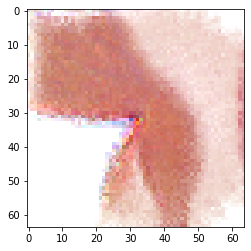

Epoch 1352, Loss: 4.522036552429199
Epoch 1353, Loss: 5.054705619812012
Epoch 1354, Loss: 5.3834052085876465
Epoch 1355, Loss: 6.989343643188477
Epoch 1356, Loss: 5.947614669799805
Epoch 1357, Loss: 6.42542028427124
Epoch 1358, Loss: 5.0705060958862305
Epoch 1359, Loss: 5.59044075012207
Epoch 1360, Loss: 5.320662975311279
Epoch 1361, Loss: 5.24323844909668
Epoch 1362, Loss: 5.010380744934082
Epoch 1363, Loss: 5.910987377166748
Epoch 1364, Loss: 5.063309669494629
Epoch 1365, Loss: 5.845555782318115
Epoch 1366, Loss: 4.5932817459106445
Epoch 1367, Loss: 4.95882511138916
Epoch 1368, Loss: 5.0847392082214355
Epoch 1369, Loss: 6.383176803588867
Epoch 1370, Loss: 5.9744133949279785
Epoch 1371, Loss: 4.606026649475098
Epoch 1372, Loss: 4.722386837005615
Epoch 1373, Loss: 4.729467391967773
Epoch 1374, Loss: 5.799243450164795
Epoch 1375, Loss: 6.156442165374756


Epoch 1376, Loss: 4.510905742645264


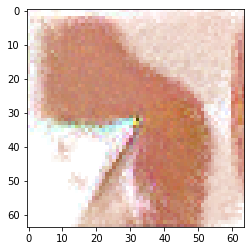

Epoch 1377, Loss: 4.593443393707275
Epoch 1378, Loss: 4.990755558013916
Epoch 1379, Loss: 4.543778419494629
Epoch 1380, Loss: 7.176214218139648
Epoch 1381, Loss: 4.7620849609375
Epoch 1382, Loss: 5.876882553100586
Epoch 1383, Loss: 6.0471272468566895
Epoch 1384, Loss: 4.435420036315918
Epoch 1385, Loss: 4.428546905517578
Epoch 1386, Loss: 4.754309177398682
Epoch 1387, Loss: 4.685894966125488
Epoch 1388, Loss: 5.07429838180542
Epoch 1389, Loss: 4.799157619476318
Epoch 1390, Loss: 4.549906253814697
Epoch 1391, Loss: 5.491609573364258
Epoch 1392, Loss: 4.776856899261475
Epoch 1393, Loss: 5.225018501281738
Epoch 1394, Loss: 4.284915447235107
Epoch 1395, Loss: 4.596948623657227
Epoch 1396, Loss: 6.4431538581848145
Epoch 1397, Loss: 4.706662178039551
Epoch 1398, Loss: 5.014482021331787
Epoch 1399, Loss: 4.145376205444336
Epoch 1400, Loss: 5.594881057739258


Epoch 1401, Loss: 4.660280704498291


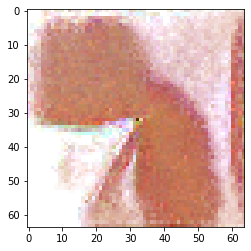

Epoch 1402, Loss: 5.30525541305542
Epoch 1403, Loss: 4.630090236663818
Epoch 1404, Loss: 5.909649848937988
Epoch 1405, Loss: 4.617317199707031
Epoch 1406, Loss: 4.289091110229492
Epoch 1407, Loss: 4.378678798675537
Epoch 1408, Loss: 5.563976764678955
Epoch 1409, Loss: 4.636507987976074
Epoch 1410, Loss: 4.304311275482178
Epoch 1411, Loss: 4.670011043548584
Epoch 1412, Loss: 5.070601463317871
Epoch 1413, Loss: 4.788391590118408
Epoch 1414, Loss: 6.052706241607666
Epoch 1415, Loss: 4.960542678833008
Epoch 1416, Loss: 5.334466934204102
Epoch 1417, Loss: 5.8693528175354
Epoch 1418, Loss: 4.507915496826172
Epoch 1419, Loss: 4.71047306060791
Epoch 1420, Loss: 4.660419940948486
Epoch 1421, Loss: 4.783428192138672
Epoch 1422, Loss: 5.72907018661499
Epoch 1423, Loss: 6.147951126098633
Epoch 1424, Loss: 5.408782005310059
Epoch 1425, Loss: 4.898266792297363


Epoch 1426, Loss: 5.214990139007568


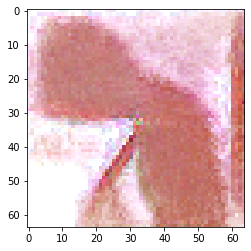

Epoch 1427, Loss: 5.748203277587891
Epoch 1428, Loss: 4.690008640289307
Epoch 1429, Loss: 4.739692687988281
Epoch 1430, Loss: 4.274045467376709
Epoch 1431, Loss: 5.391379356384277
Epoch 1432, Loss: 4.3392839431762695
Epoch 1433, Loss: 4.566708087921143
Epoch 1434, Loss: 5.050480365753174
Epoch 1435, Loss: 4.748823165893555
Epoch 1436, Loss: 5.002407550811768
Epoch 1437, Loss: 4.830254077911377
Epoch 1438, Loss: 4.514228343963623
Epoch 1439, Loss: 4.314355850219727
Epoch 1440, Loss: 7.1623454093933105
Epoch 1441, Loss: 4.56299352645874
Epoch 1442, Loss: 4.386962413787842
Epoch 1443, Loss: 4.5606913566589355
Epoch 1444, Loss: 7.414793014526367
Epoch 1445, Loss: 5.841920375823975
Epoch 1446, Loss: 4.839612007141113
Epoch 1447, Loss: 4.765985012054443
Epoch 1448, Loss: 4.594837665557861
Epoch 1449, Loss: 5.967959403991699
Epoch 1450, Loss: 6.455379486083984


Epoch 1451, Loss: 5.352336883544922


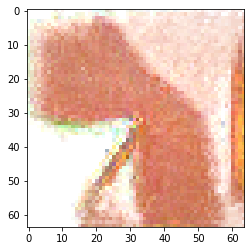

Epoch 1452, Loss: 6.0776872634887695
Epoch 1453, Loss: 5.691690444946289
Epoch 1454, Loss: 6.413278102874756
Epoch 1455, Loss: 5.1945390701293945
Epoch 1456, Loss: 5.228150367736816
Epoch 1457, Loss: 5.685378551483154
Epoch 1458, Loss: 5.275307655334473
Epoch 1459, Loss: 5.062030792236328
Epoch 1460, Loss: 5.472130298614502
Epoch 1461, Loss: 5.676292896270752
Epoch 1462, Loss: 5.092719078063965
Epoch 1463, Loss: 4.668884754180908
Epoch 1464, Loss: 4.888554573059082
Epoch 1465, Loss: 5.131436824798584
Epoch 1466, Loss: 5.561762809753418
Epoch 1467, Loss: 4.6127424240112305
Epoch 1468, Loss: 4.863341808319092
Epoch 1469, Loss: 4.565561771392822
Epoch 1470, Loss: 4.560047149658203
Epoch 1471, Loss: 4.6010823249816895
Epoch 1472, Loss: 5.025694370269775
Epoch 1473, Loss: 5.262913227081299
Epoch 1474, Loss: 4.919233322143555
Epoch 1475, Loss: 8.411200523376465


Epoch 1476, Loss: 5.204750061035156


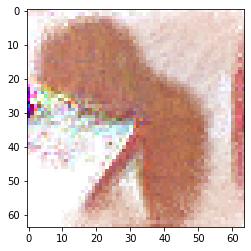

Epoch 1477, Loss: 5.57192850112915
Epoch 1478, Loss: 6.481257915496826
Epoch 1479, Loss: 5.267557621002197
Epoch 1480, Loss: 5.4328932762146
Epoch 1481, Loss: 4.940905570983887
Epoch 1482, Loss: 5.001482963562012
Epoch 1483, Loss: 5.42936897277832
Epoch 1484, Loss: 5.943222999572754
Epoch 1485, Loss: 5.930334091186523
Epoch 1486, Loss: 4.934831142425537
Epoch 1487, Loss: 5.105885982513428
Epoch 1488, Loss: 4.891557216644287
Epoch 1489, Loss: 4.868814468383789
Epoch 1490, Loss: 5.520851135253906
Epoch 1491, Loss: 5.105923652648926
Epoch 1492, Loss: 5.537201881408691
Epoch 1493, Loss: 6.822695732116699
Epoch 1494, Loss: 5.433599472045898
Epoch 1495, Loss: 5.7880682945251465
Epoch 1496, Loss: 4.495756149291992
Epoch 1497, Loss: 4.438971519470215
Epoch 1498, Loss: 6.882420063018799
Epoch 1499, Loss: 5.539918899536133
Epoch 1500, Loss: 6.807316780090332


Epoch 1501, Loss: 4.54557466506958


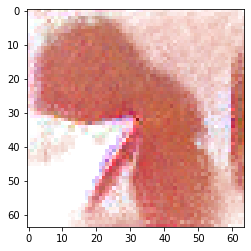

Epoch 1502, Loss: 4.446163177490234
Epoch 1503, Loss: 7.092243194580078
Epoch 1504, Loss: 5.07682991027832
Epoch 1505, Loss: 4.585082530975342
Epoch 1506, Loss: 5.201350212097168
Epoch 1507, Loss: 5.035888195037842
Epoch 1508, Loss: 6.734169960021973
Epoch 1509, Loss: 5.993306636810303
Epoch 1510, Loss: 5.717782497406006
Epoch 1511, Loss: 4.483338832855225
Epoch 1512, Loss: 4.568916320800781
Epoch 1513, Loss: 4.925819396972656
Epoch 1514, Loss: 5.622363567352295
Epoch 1515, Loss: 5.0135321617126465
Epoch 1516, Loss: 5.326448917388916
Epoch 1517, Loss: 5.391629219055176
Epoch 1518, Loss: 5.388612270355225
Epoch 1519, Loss: 4.6547112464904785
Epoch 1520, Loss: 4.785787105560303
Epoch 1521, Loss: 5.281357288360596
Epoch 1522, Loss: 4.752487659454346
Epoch 1523, Loss: 6.243788242340088
Epoch 1524, Loss: 4.3800225257873535
Epoch 1525, Loss: 4.490536212921143


Epoch 1526, Loss: 4.4052958488464355


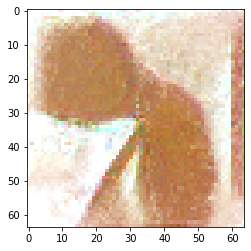

Epoch 1527, Loss: 4.4607439041137695
Epoch 1528, Loss: 4.614611625671387
Epoch 1529, Loss: 4.887779235839844
Epoch 1530, Loss: 4.149165630340576
Epoch 1531, Loss: 5.092531204223633
Epoch 1532, Loss: 4.664529323577881
Epoch 1533, Loss: 5.1352105140686035
Epoch 1534, Loss: 5.433609485626221
Epoch 1535, Loss: 4.700763702392578
Epoch 1536, Loss: 5.7463884353637695
Epoch 1537, Loss: 4.305445194244385
Epoch 1538, Loss: 4.1151580810546875
Epoch 1539, Loss: 4.197242259979248
Epoch 1540, Loss: 4.9163737297058105
Epoch 1541, Loss: 6.126274585723877
Epoch 1542, Loss: 5.136910915374756
Epoch 1543, Loss: 4.579548358917236
Epoch 1544, Loss: 4.978907108306885
Epoch 1545, Loss: 4.376463890075684
Epoch 1546, Loss: 4.582467079162598
Epoch 1547, Loss: 4.906968593597412
Epoch 1548, Loss: 5.695878505706787
Epoch 1549, Loss: 4.428840637207031
Epoch 1550, Loss: 4.110030174255371


Epoch 1551, Loss: 4.113574504852295


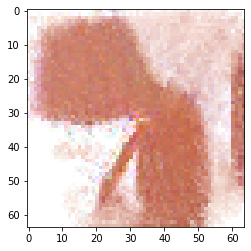

Epoch 1552, Loss: 4.292214870452881
Epoch 1553, Loss: 4.262751579284668
Epoch 1554, Loss: 4.562123775482178
Epoch 1555, Loss: 4.643534183502197
Epoch 1556, Loss: 5.5468950271606445
Epoch 1557, Loss: 4.547079086303711
Epoch 1558, Loss: 5.284919261932373
Epoch 1559, Loss: 4.272861957550049
Epoch 1560, Loss: 4.799723148345947
Epoch 1561, Loss: 7.232447147369385
Epoch 1562, Loss: 4.38433313369751
Epoch 1563, Loss: 4.981176376342773
Epoch 1564, Loss: 4.344938278198242
Epoch 1565, Loss: 4.591149806976318
Epoch 1566, Loss: 4.966683864593506
Epoch 1567, Loss: 4.989570617675781
Epoch 1568, Loss: 5.071257591247559
Epoch 1569, Loss: 4.579476356506348
Epoch 1570, Loss: 4.844512462615967
Epoch 1571, Loss: 3.9323596954345703
Epoch 1572, Loss: 4.165464401245117
Epoch 1573, Loss: 4.328160762786865
Epoch 1574, Loss: 4.770546913146973
Epoch 1575, Loss: 4.935295104980469


Epoch 1576, Loss: 5.198108196258545


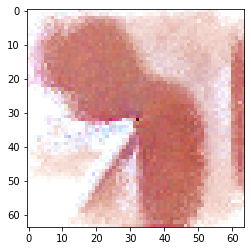

Epoch 1577, Loss: 4.306129455566406
Epoch 1578, Loss: 4.739145755767822
Epoch 1579, Loss: 5.698757648468018
Epoch 1580, Loss: 4.952727317810059
Epoch 1581, Loss: 5.350491046905518
Epoch 1582, Loss: 7.5314812660217285
Epoch 1583, Loss: 5.1837992668151855
Epoch 1584, Loss: 4.6722846031188965
Epoch 1585, Loss: 4.847104549407959
Epoch 1586, Loss: 5.0084228515625
Epoch 1587, Loss: 5.495893955230713
Epoch 1588, Loss: 6.3368425369262695
Epoch 1589, Loss: 5.275644779205322
Epoch 1590, Loss: 5.422672748565674
Epoch 1591, Loss: 5.283085823059082
Epoch 1592, Loss: 5.4340996742248535
Epoch 1593, Loss: 4.827004432678223
Epoch 1594, Loss: 6.197188854217529
Epoch 1595, Loss: 5.055771827697754
Epoch 1596, Loss: 5.014830589294434
Epoch 1597, Loss: 5.564622402191162
Epoch 1598, Loss: 4.399989128112793
Epoch 1599, Loss: 5.479343414306641
Epoch 1600, Loss: 5.10762357711792


Epoch 1601, Loss: 4.749810695648193


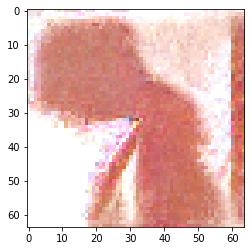

Epoch 1602, Loss: 4.865241050720215
Epoch 1603, Loss: 5.111443996429443
Epoch 1604, Loss: 5.453614234924316
Epoch 1605, Loss: 4.762393474578857
Epoch 1606, Loss: 5.239535331726074
Epoch 1607, Loss: 4.523587703704834
Epoch 1608, Loss: 4.453830242156982
Epoch 1609, Loss: 4.118479251861572
Epoch 1610, Loss: 5.191749095916748
Epoch 1611, Loss: 4.2424163818359375
Epoch 1612, Loss: 4.786340713500977
Epoch 1613, Loss: 4.780999660491943
Epoch 1614, Loss: 3.9184107780456543
Epoch 1615, Loss: 4.27724027633667
Epoch 1616, Loss: 4.094001770019531
Epoch 1617, Loss: 4.32208776473999
Epoch 1618, Loss: 4.101194381713867
Epoch 1619, Loss: 3.868586540222168
Epoch 1620, Loss: 4.138286590576172
Epoch 1621, Loss: 4.239326000213623
Epoch 1622, Loss: 4.935214519500732
Epoch 1623, Loss: 4.284060955047607
Epoch 1624, Loss: 4.467472553253174
Epoch 1625, Loss: 5.5157551765441895


Epoch 1626, Loss: 4.360107898712158


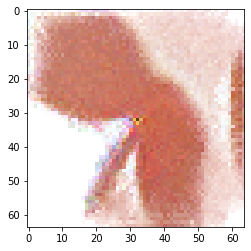

Epoch 1627, Loss: 4.249188423156738
Epoch 1628, Loss: 5.261062145233154
Epoch 1629, Loss: 5.472214698791504
Epoch 1630, Loss: 4.320260047912598
Epoch 1631, Loss: 4.923084735870361
Epoch 1632, Loss: 5.306425094604492
Epoch 1633, Loss: 5.044956207275391
Epoch 1634, Loss: 4.294273853302002
Epoch 1635, Loss: 5.621788501739502
Epoch 1636, Loss: 5.4811811447143555
Epoch 1637, Loss: 4.856409549713135
Epoch 1638, Loss: 6.004971981048584
Epoch 1639, Loss: 5.282825469970703
Epoch 1640, Loss: 5.707061767578125
Epoch 1641, Loss: 4.892367839813232
Epoch 1642, Loss: 4.861226558685303
Epoch 1643, Loss: 5.2443766593933105
Epoch 1644, Loss: 4.756627559661865
Epoch 1645, Loss: 5.125223159790039
Epoch 1646, Loss: 4.752457141876221
Epoch 1647, Loss: 4.511819839477539
Epoch 1648, Loss: 4.371168613433838
Epoch 1649, Loss: 4.72533655166626
Epoch 1650, Loss: 4.872926712036133


Epoch 1651, Loss: 5.973254203796387


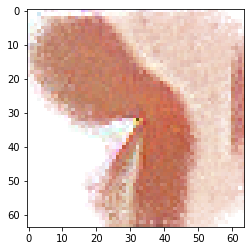

Epoch 1652, Loss: 4.515251159667969
Epoch 1653, Loss: 4.754995346069336
Epoch 1654, Loss: 5.183408737182617
Epoch 1655, Loss: 4.099743843078613
Epoch 1656, Loss: 4.391737461090088
Epoch 1657, Loss: 4.686307430267334
Epoch 1658, Loss: 6.982829570770264
Epoch 1659, Loss: 4.360787391662598
Epoch 1660, Loss: 4.953309059143066
Epoch 1661, Loss: 5.754382133483887
Epoch 1662, Loss: 4.293997287750244
Epoch 1663, Loss: 4.014952659606934
Epoch 1664, Loss: 5.964134216308594
Epoch 1665, Loss: 4.218383312225342
Epoch 1666, Loss: 5.734340190887451
Epoch 1667, Loss: 4.5889573097229
Epoch 1668, Loss: 4.363280296325684
Epoch 1669, Loss: 5.941262245178223
Epoch 1670, Loss: 5.939891338348389
Epoch 1671, Loss: 4.309162616729736
Epoch 1672, Loss: 4.054664611816406
Epoch 1673, Loss: 4.586484432220459
Epoch 1674, Loss: 4.802751541137695
Epoch 1675, Loss: 5.182187557220459


Epoch 1676, Loss: 4.515885353088379


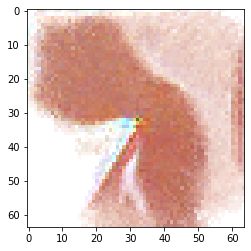

Epoch 1677, Loss: 5.1062493324279785
Epoch 1678, Loss: 5.24668025970459
Epoch 1679, Loss: 4.129096031188965
Epoch 1680, Loss: 5.05699348449707
Epoch 1681, Loss: 4.715074062347412
Epoch 1682, Loss: 4.483665466308594
Epoch 1683, Loss: 4.149684906005859
Epoch 1684, Loss: 4.454910755157471
Epoch 1685, Loss: 4.326239585876465
Epoch 1686, Loss: 4.670428276062012
Epoch 1687, Loss: 4.265135765075684
Epoch 1688, Loss: 4.049077987670898
Epoch 1689, Loss: 4.3928093910217285
Epoch 1690, Loss: 5.011585235595703
Epoch 1691, Loss: 3.9833226203918457
Epoch 1692, Loss: 3.778376817703247
Epoch 1693, Loss: 4.508699417114258
Epoch 1694, Loss: 4.1242523193359375
Epoch 1695, Loss: 4.027174949645996
Epoch 1696, Loss: 6.382513999938965
Epoch 1697, Loss: 4.543233871459961
Epoch 1698, Loss: 4.447322845458984
Epoch 1699, Loss: 6.051838397979736
Epoch 1700, Loss: 5.023592948913574


Epoch 1701, Loss: 5.549879550933838


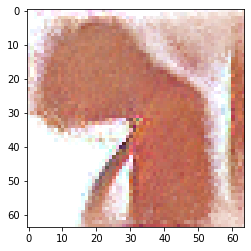

Epoch 1702, Loss: 4.601847171783447
Epoch 1703, Loss: 5.687991142272949
Epoch 1704, Loss: 4.781304836273193
Epoch 1705, Loss: 5.459658622741699
Epoch 1706, Loss: 4.1189727783203125
Epoch 1707, Loss: 5.168429374694824
Epoch 1708, Loss: 5.39206600189209
Epoch 1709, Loss: 4.461638450622559
Epoch 1710, Loss: 4.218913555145264
Epoch 1711, Loss: 4.545376777648926
Epoch 1712, Loss: 4.397765159606934
Epoch 1713, Loss: 4.905250072479248
Epoch 1714, Loss: 4.915466785430908
Epoch 1715, Loss: 5.498035430908203
Epoch 1716, Loss: 5.307678699493408
Epoch 1717, Loss: 4.566186428070068
Epoch 1718, Loss: 4.385807037353516
Epoch 1719, Loss: 4.195253372192383
Epoch 1720, Loss: 4.761307716369629
Epoch 1721, Loss: 4.260387420654297
Epoch 1722, Loss: 4.50814962387085
Epoch 1723, Loss: 4.317711353302002
Epoch 1724, Loss: 4.430192947387695
Epoch 1725, Loss: 4.060664176940918


Epoch 1726, Loss: 4.63599967956543


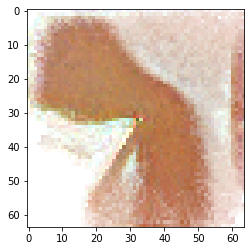

Epoch 1727, Loss: 4.010186195373535
Epoch 1728, Loss: 3.8882601261138916
Epoch 1729, Loss: 5.539221286773682
Epoch 1730, Loss: 4.807673454284668
Epoch 1731, Loss: 3.9267630577087402
Epoch 1732, Loss: 5.332709312438965
Epoch 1733, Loss: 5.340120315551758
Epoch 1734, Loss: 5.014902114868164
Epoch 1735, Loss: 4.2136406898498535
Epoch 1736, Loss: 3.9300718307495117
Epoch 1737, Loss: 4.278779983520508
Epoch 1738, Loss: 4.106459140777588
Epoch 1739, Loss: 4.779332637786865
Epoch 1740, Loss: 4.283398151397705
Epoch 1741, Loss: 4.124281406402588
Epoch 1742, Loss: 3.8890700340270996
Epoch 1743, Loss: 3.6050949096679688
Epoch 1744, Loss: 3.8341925144195557
Epoch 1745, Loss: 3.7068958282470703
Epoch 1746, Loss: 5.261209011077881
Epoch 1747, Loss: 3.8142435550689697
Epoch 1748, Loss: 4.071146011352539
Epoch 1749, Loss: 5.457983016967773
Epoch 1750, Loss: 5.289525508880615


Epoch 1751, Loss: 3.8737952709198


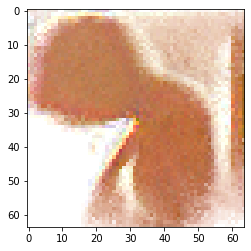

Epoch 1752, Loss: 5.017840385437012
Epoch 1753, Loss: 6.046133995056152
Epoch 1754, Loss: 4.75486946105957
Epoch 1755, Loss: 5.498617172241211
Epoch 1756, Loss: 6.2277302742004395
Epoch 1757, Loss: 5.375072956085205
Epoch 1758, Loss: 5.078486919403076
Epoch 1759, Loss: 4.065492630004883
Epoch 1760, Loss: 4.418280124664307
Epoch 1761, Loss: 4.296422004699707
Epoch 1762, Loss: 4.2321085929870605
Epoch 1763, Loss: 5.085263252258301
Epoch 1764, Loss: 3.9974002838134766
Epoch 1765, Loss: 7.091829299926758
Epoch 1766, Loss: 4.382270336151123
Epoch 1767, Loss: 5.559023380279541
Epoch 1768, Loss: 5.116199016571045
Epoch 1769, Loss: 4.8737101554870605
Epoch 1770, Loss: 3.962190866470337
Epoch 1771, Loss: 4.843147277832031
Epoch 1772, Loss: 3.69022274017334
Epoch 1773, Loss: 3.828516960144043
Epoch 1774, Loss: 4.775659561157227
Epoch 1775, Loss: 4.66111421585083


Epoch 1776, Loss: 4.047895431518555


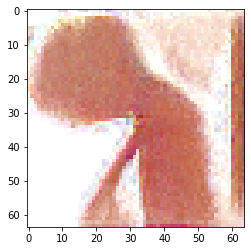

Epoch 1777, Loss: 4.051966190338135
Epoch 1778, Loss: 4.147702693939209
Epoch 1779, Loss: 4.595714569091797
Epoch 1780, Loss: 4.438335418701172
Epoch 1781, Loss: 4.023984909057617
Epoch 1782, Loss: 3.7150464057922363
Epoch 1783, Loss: 3.938589334487915
Epoch 1784, Loss: 5.913428783416748
Epoch 1785, Loss: 3.710235357284546
Epoch 1786, Loss: 3.969135046005249
Epoch 1787, Loss: 3.8101022243499756
Epoch 1788, Loss: 3.8595356941223145
Epoch 1789, Loss: 4.131755828857422
Epoch 1790, Loss: 3.853229522705078
Epoch 1791, Loss: 3.9777636528015137
Epoch 1792, Loss: 3.73258638381958
Epoch 1793, Loss: 5.521523952484131
Epoch 1794, Loss: 5.898847579956055
Epoch 1795, Loss: 6.111489295959473
Epoch 1796, Loss: 4.6174139976501465
Epoch 1797, Loss: 5.782111167907715
Epoch 1798, Loss: 4.407270431518555
Epoch 1799, Loss: 6.473950386047363
Epoch 1800, Loss: 5.922463417053223


Epoch 1801, Loss: 4.473465919494629


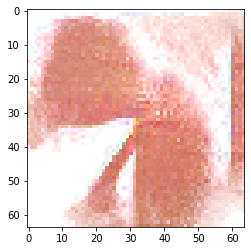

Epoch 1802, Loss: 5.718987464904785
Epoch 1803, Loss: 4.774011135101318
Epoch 1804, Loss: 5.1355438232421875
Epoch 1805, Loss: 4.276576519012451
Epoch 1806, Loss: 5.195394992828369
Epoch 1807, Loss: 4.752655029296875
Epoch 1808, Loss: 4.639027118682861
Epoch 1809, Loss: 4.594239234924316
Epoch 1810, Loss: 4.930265426635742
Epoch 1811, Loss: 5.354869365692139
Epoch 1812, Loss: 4.139736652374268
Epoch 1813, Loss: 4.13527250289917
Epoch 1814, Loss: 4.243640422821045
Epoch 1815, Loss: 3.9399542808532715
Epoch 1816, Loss: 4.439794063568115
Epoch 1817, Loss: 3.8559985160827637
Epoch 1818, Loss: 4.204541206359863
Epoch 1819, Loss: 3.700019359588623
Epoch 1820, Loss: 5.506844997406006
Epoch 1821, Loss: 4.058663368225098
Epoch 1822, Loss: 3.7165377140045166
Epoch 1823, Loss: 3.924027919769287
Epoch 1824, Loss: 4.451863765716553
Epoch 1825, Loss: 4.525217533111572


Epoch 1826, Loss: 3.648261070251465


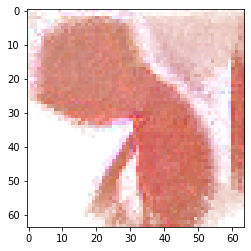

Epoch 1827, Loss: 4.038725852966309
Epoch 1828, Loss: 4.171089172363281
Epoch 1829, Loss: 5.578074932098389
Epoch 1830, Loss: 5.256370544433594
Epoch 1831, Loss: 3.859647750854492
Epoch 1832, Loss: 3.7651405334472656
Epoch 1833, Loss: 4.598962783813477
Epoch 1834, Loss: 3.5842320919036865
Epoch 1835, Loss: 4.069118022918701
Epoch 1836, Loss: 3.574704647064209
Epoch 1837, Loss: 6.37431001663208
Epoch 1838, Loss: 3.8605477809906006
Epoch 1839, Loss: 5.624896049499512
Epoch 1840, Loss: 4.441678047180176
Epoch 1841, Loss: 5.615899085998535
Epoch 1842, Loss: 3.9487857818603516
Epoch 1843, Loss: 4.286116600036621
Epoch 1844, Loss: 4.380666255950928
Epoch 1845, Loss: 3.9980549812316895
Epoch 1846, Loss: 4.885652542114258
Epoch 1847, Loss: 4.029430389404297
Epoch 1848, Loss: 4.016560077667236
Epoch 1849, Loss: 5.104191303253174
Epoch 1850, Loss: 4.505945682525635


Epoch 1851, Loss: 4.243908882141113


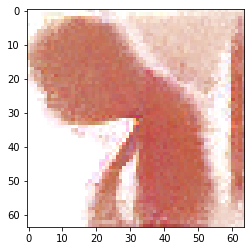

Epoch 1852, Loss: 4.11259126663208
Epoch 1853, Loss: 4.106011867523193
Epoch 1854, Loss: 4.864208698272705
Epoch 1855, Loss: 4.417909145355225
Epoch 1856, Loss: 4.450158596038818
Epoch 1857, Loss: 4.201664924621582
Epoch 1858, Loss: 4.174225807189941
Epoch 1859, Loss: 4.400724411010742
Epoch 1860, Loss: 3.8352184295654297
Epoch 1861, Loss: 3.837740898132324
Epoch 1862, Loss: 4.40917444229126
Epoch 1863, Loss: 5.100170612335205
Epoch 1864, Loss: 4.72320556640625
Epoch 1865, Loss: 5.110441207885742
Epoch 1866, Loss: 4.275767803192139
Epoch 1867, Loss: 4.074147701263428
Epoch 1868, Loss: 5.1893630027771
Epoch 1869, Loss: 4.25747013092041
Epoch 1870, Loss: 4.530836582183838
Epoch 1871, Loss: 4.276896953582764
Epoch 1872, Loss: 5.455289840698242
Epoch 1873, Loss: 4.4287543296813965
Epoch 1874, Loss: 4.200960159301758
Epoch 1875, Loss: 3.6862876415252686


Epoch 1876, Loss: 4.281426429748535


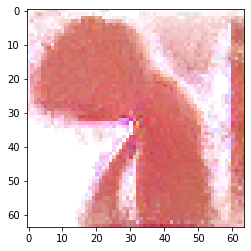

Epoch 1877, Loss: 4.105403900146484
Epoch 1878, Loss: 4.195411205291748
Epoch 1879, Loss: 4.811506748199463
Epoch 1880, Loss: 3.7798900604248047
Epoch 1881, Loss: 4.280547618865967
Epoch 1882, Loss: 3.8726978302001953
Epoch 1883, Loss: 4.591561317443848
Epoch 1884, Loss: 5.062910079956055
Epoch 1885, Loss: 3.713730812072754
Epoch 1886, Loss: 4.6587700843811035
Epoch 1887, Loss: 4.823653697967529
Epoch 1888, Loss: 4.7038373947143555
Epoch 1889, Loss: 4.414165496826172
Epoch 1890, Loss: 3.853508949279785
Epoch 1891, Loss: 5.650016784667969
Epoch 1892, Loss: 4.1249613761901855
Epoch 1893, Loss: 4.06948184967041
Epoch 1894, Loss: 4.883533954620361
Epoch 1895, Loss: 4.436715126037598
Epoch 1896, Loss: 4.355193138122559
Epoch 1897, Loss: 4.011837005615234
Epoch 1898, Loss: 4.0083417892456055
Epoch 1899, Loss: 4.193967819213867
Epoch 1900, Loss: 3.5870938301086426


Epoch 1901, Loss: 5.164375305175781


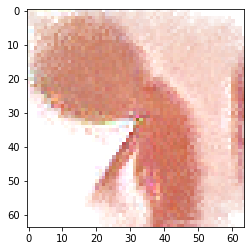

Epoch 1902, Loss: 4.089434623718262
Epoch 1903, Loss: 4.1469011306762695
Epoch 1904, Loss: 6.028263092041016
Epoch 1905, Loss: 4.1174845695495605
Epoch 1906, Loss: 5.293422222137451
Epoch 1907, Loss: 5.10020637512207
Epoch 1908, Loss: 5.367845058441162
Epoch 1909, Loss: 4.050337314605713
Epoch 1910, Loss: 3.974337100982666
Epoch 1911, Loss: 3.7963335514068604
Epoch 1912, Loss: 5.867882251739502
Epoch 1913, Loss: 4.886539936065674
Epoch 1914, Loss: 4.684622764587402
Epoch 1915, Loss: 5.280703544616699
Epoch 1916, Loss: 4.785562515258789
Epoch 1917, Loss: 5.012732982635498
Epoch 1918, Loss: 4.076102256774902
Epoch 1919, Loss: 4.221720218658447
Epoch 1920, Loss: 4.457975387573242
Epoch 1921, Loss: 4.5647101402282715
Epoch 1922, Loss: 4.45397424697876
Epoch 1923, Loss: 3.893423557281494
Epoch 1924, Loss: 4.045102596282959
Epoch 1925, Loss: 4.971516132354736


Epoch 1926, Loss: 4.016080379486084


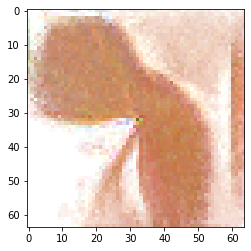

Epoch 1927, Loss: 5.032215118408203
Epoch 1928, Loss: 4.322360992431641
Epoch 1929, Loss: 4.011528015136719
Epoch 1930, Loss: 4.296855449676514
Epoch 1931, Loss: 4.599611282348633
Epoch 1932, Loss: 3.978923797607422
Epoch 1933, Loss: 3.76623272895813
Epoch 1934, Loss: 3.819866418838501
Epoch 1935, Loss: 3.6604809761047363
Epoch 1936, Loss: 3.584782361984253
Epoch 1937, Loss: 3.8390145301818848
Epoch 1938, Loss: 4.320484161376953
Epoch 1939, Loss: 4.841831207275391
Epoch 1940, Loss: 5.03902530670166
Epoch 1941, Loss: 4.352916240692139
Epoch 1942, Loss: 4.374351978302002
Epoch 1943, Loss: 5.11007833480835
Epoch 1944, Loss: 3.7352635860443115
Epoch 1945, Loss: 3.7692480087280273
Epoch 1946, Loss: 4.5134148597717285
Epoch 1947, Loss: 5.273923873901367
Epoch 1948, Loss: 5.173539638519287
Epoch 1949, Loss: 4.886714458465576
Epoch 1950, Loss: 5.098143100738525


Epoch 1951, Loss: 5.24478816986084


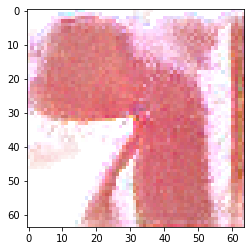

Epoch 1952, Loss: 4.397171974182129
Epoch 1953, Loss: 5.018959045410156
Epoch 1954, Loss: 4.492043495178223
Epoch 1955, Loss: 5.237522125244141
Epoch 1956, Loss: 5.286798477172852
Epoch 1957, Loss: 4.989685535430908
Epoch 1958, Loss: 4.622100830078125
Epoch 1959, Loss: 4.3924560546875
Epoch 1960, Loss: 4.88123893737793
Epoch 1961, Loss: 4.701630592346191
Epoch 1962, Loss: 4.403797626495361
Epoch 1963, Loss: 4.22438383102417
Epoch 1964, Loss: 3.908360004425049
Epoch 1965, Loss: 6.6824631690979
Epoch 1966, Loss: 4.289365768432617
Epoch 1967, Loss: 4.0514936447143555
Epoch 1968, Loss: 4.24519157409668
Epoch 1969, Loss: 4.826359272003174
Epoch 1970, Loss: 5.467235088348389
Epoch 1971, Loss: 4.709550857543945
Epoch 1972, Loss: 3.8519225120544434
Epoch 1973, Loss: 5.123920917510986
Epoch 1974, Loss: 4.701003551483154
Epoch 1975, Loss: 4.12919807434082


Epoch 1976, Loss: 5.142605781555176


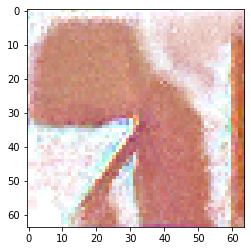

Epoch 1977, Loss: 4.408384323120117
Epoch 1978, Loss: 4.630615234375
Epoch 1979, Loss: 4.139483451843262
Epoch 1980, Loss: 4.377697944641113
Epoch 1981, Loss: 4.273935794830322
Epoch 1982, Loss: 4.046005725860596
Epoch 1983, Loss: 3.658445119857788
Epoch 1984, Loss: 3.559804677963257
Epoch 1985, Loss: 3.958641767501831
Epoch 1986, Loss: 7.105754375457764
Epoch 1987, Loss: 3.7074339389801025
Epoch 1988, Loss: 3.7656335830688477
Epoch 1989, Loss: 6.617253303527832
Epoch 1990, Loss: 3.9553213119506836
Epoch 1991, Loss: 3.632903814315796
Epoch 1992, Loss: 3.793299674987793
Epoch 1993, Loss: 6.498640060424805
Epoch 1994, Loss: 3.5423784255981445
Epoch 1995, Loss: 3.7362852096557617
Epoch 1996, Loss: 3.6377816200256348
Epoch 1997, Loss: 3.7215654850006104
Epoch 1998, Loss: 4.624944686889648
Epoch 1999, Loss: 3.5938448905944824
Epoch 2000, Loss: 3.6568057537078857


Epoch 2001, Loss: 3.969273090362549


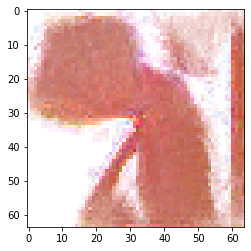

Epoch 2002, Loss: 6.261341094970703
Epoch 2003, Loss: 5.621977806091309
Epoch 2004, Loss: 4.298412322998047
Epoch 2005, Loss: 6.24063777923584
Epoch 2006, Loss: 3.8466241359710693
Epoch 2007, Loss: 6.2539963722229
Epoch 2008, Loss: 4.366741180419922
Epoch 2009, Loss: 4.803752899169922
Epoch 2010, Loss: 5.060347080230713
Epoch 2011, Loss: 3.8514771461486816
Epoch 2012, Loss: 4.518131256103516
Epoch 2013, Loss: 4.556264877319336
Epoch 2014, Loss: 5.494125843048096
Epoch 2015, Loss: 5.236861705780029
Epoch 2016, Loss: 4.419530391693115
Epoch 2017, Loss: 4.943268299102783
Epoch 2018, Loss: 4.31420373916626
Epoch 2019, Loss: 4.33518648147583
Epoch 2020, Loss: 4.7546305656433105
Epoch 2021, Loss: 4.023734092712402
Epoch 2022, Loss: 4.205264091491699
Epoch 2023, Loss: 6.302036285400391
Epoch 2024, Loss: 3.930101156234741
Epoch 2025, Loss: 4.2360968589782715


Epoch 2026, Loss: 3.9866857528686523


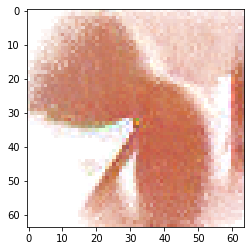

Epoch 2027, Loss: 5.029018402099609
Epoch 2028, Loss: 4.054120063781738
Epoch 2029, Loss: 4.676031112670898
Epoch 2030, Loss: 4.277276515960693
Epoch 2031, Loss: 6.182378768920898
Epoch 2032, Loss: 3.931753635406494
Epoch 2033, Loss: 4.004066467285156
Epoch 2034, Loss: 4.12770414352417
Epoch 2035, Loss: 4.3007097244262695
Epoch 2036, Loss: 4.413358211517334
Epoch 2037, Loss: 4.205633640289307
Epoch 2038, Loss: 4.771519660949707
Epoch 2039, Loss: 3.935734272003174
Epoch 2040, Loss: 4.613247871398926
Epoch 2041, Loss: 4.29906702041626
Epoch 2042, Loss: 3.8374979496002197
Epoch 2043, Loss: 3.7613935470581055
Epoch 2044, Loss: 4.490545749664307
Epoch 2045, Loss: 4.448339939117432
Epoch 2046, Loss: 4.000843524932861
Epoch 2047, Loss: 3.8510336875915527
Epoch 2048, Loss: 3.7839229106903076
Epoch 2049, Loss: 4.349620819091797
Epoch 2050, Loss: 4.337977409362793


Epoch 2051, Loss: 4.576003074645996


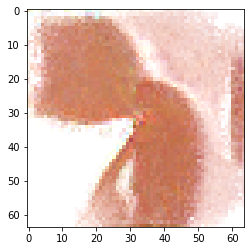

Epoch 2052, Loss: 4.208787441253662
Epoch 2053, Loss: 4.031721591949463
Epoch 2054, Loss: 4.172896385192871
Epoch 2055, Loss: 4.258905410766602
Epoch 2056, Loss: 3.8406736850738525
Epoch 2057, Loss: 4.419269561767578
Epoch 2058, Loss: 4.137246131896973
Epoch 2059, Loss: 3.9657227993011475
Epoch 2060, Loss: 4.25390625
Epoch 2061, Loss: 4.103750228881836
Epoch 2062, Loss: 4.000837802886963
Epoch 2063, Loss: 4.222357749938965
Epoch 2064, Loss: 5.318628787994385
Epoch 2065, Loss: 3.7667226791381836
Epoch 2066, Loss: 3.9566807746887207
Epoch 2067, Loss: 4.096260070800781
Epoch 2068, Loss: 4.703873157501221
Epoch 2069, Loss: 4.026608467102051
Epoch 2070, Loss: 4.180856227874756
Epoch 2071, Loss: 3.972093105316162
Epoch 2072, Loss: 3.798304796218872
Epoch 2073, Loss: 3.920097589492798
Epoch 2074, Loss: 3.560626983642578
Epoch 2075, Loss: 4.426735877990723


Epoch 2076, Loss: 4.807356834411621


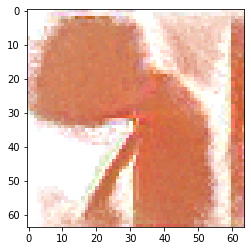

Epoch 2077, Loss: 4.636443138122559
Epoch 2078, Loss: 5.386019706726074
Epoch 2079, Loss: 4.8072991371154785
Epoch 2080, Loss: 3.9181442260742188
Epoch 2081, Loss: 3.615711212158203
Epoch 2082, Loss: 4.637854099273682
Epoch 2083, Loss: 3.720235824584961
Epoch 2084, Loss: 4.542514801025391
Epoch 2085, Loss: 3.8731746673583984
Epoch 2086, Loss: 4.888182163238525
Epoch 2087, Loss: 4.2055511474609375
Epoch 2088, Loss: 3.497955560684204
Epoch 2089, Loss: 3.355806589126587
Epoch 2090, Loss: 3.6020472049713135
Epoch 2091, Loss: 3.4861981868743896
Epoch 2092, Loss: 3.9406955242156982
Epoch 2093, Loss: 4.139974594116211
Epoch 2094, Loss: 3.4801979064941406
Epoch 2095, Loss: 4.185794830322266
Epoch 2096, Loss: 3.477339506149292
Epoch 2097, Loss: 4.024956226348877
Epoch 2098, Loss: 3.5946309566497803
Epoch 2099, Loss: 4.877776145935059
Epoch 2100, Loss: 3.9449517726898193


Epoch 2101, Loss: 4.542267799377441


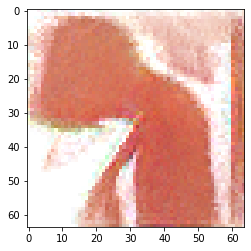

Epoch 2102, Loss: 4.620761394500732
Epoch 2103, Loss: 3.7651166915893555
Epoch 2104, Loss: 3.5945143699645996
Epoch 2105, Loss: 3.7992470264434814
Epoch 2106, Loss: 5.165366172790527
Epoch 2107, Loss: 3.4685676097869873
Epoch 2108, Loss: 3.6744329929351807
Epoch 2109, Loss: 4.789023399353027
Epoch 2110, Loss: 4.207515716552734
Epoch 2111, Loss: 3.889554262161255
Epoch 2112, Loss: 4.237157821655273
Epoch 2113, Loss: 3.3725693225860596
Epoch 2114, Loss: 3.954576253890991
Epoch 2115, Loss: 3.6821658611297607
Epoch 2116, Loss: 3.551114797592163
Epoch 2117, Loss: 3.510490894317627
Epoch 2118, Loss: 4.231024742126465
Epoch 2119, Loss: 4.256937503814697
Epoch 2120, Loss: 3.7809815406799316
Epoch 2121, Loss: 3.5207905769348145
Epoch 2122, Loss: 3.7128713130950928
Epoch 2123, Loss: 3.7667062282562256
Epoch 2124, Loss: 3.7238776683807373
Epoch 2125, Loss: 3.6244683265686035


Epoch 2126, Loss: 3.8120768070220947


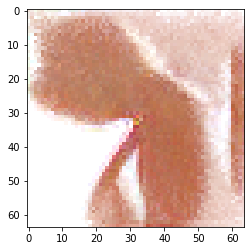

Epoch 2127, Loss: 3.6122474670410156
Epoch 2128, Loss: 3.520904779434204
Epoch 2129, Loss: 3.6222922801971436
Epoch 2130, Loss: 4.383289337158203
Epoch 2131, Loss: 4.144125938415527
Epoch 2132, Loss: 3.892162799835205
Epoch 2133, Loss: 3.4115939140319824
Epoch 2134, Loss: 3.847008466720581
Epoch 2135, Loss: 3.4391212463378906
Epoch 2136, Loss: 3.7970471382141113
Epoch 2137, Loss: 4.134873390197754
Epoch 2138, Loss: 3.500894069671631
Epoch 2139, Loss: 3.4034945964813232
Epoch 2140, Loss: 3.234647274017334
Epoch 2141, Loss: 3.8945369720458984
Epoch 2142, Loss: 3.362198829650879
Epoch 2143, Loss: 3.468623399734497
Epoch 2144, Loss: 3.4249300956726074
Epoch 2145, Loss: 6.364034652709961
Epoch 2146, Loss: 4.587703227996826
Epoch 2147, Loss: 3.9861326217651367
Epoch 2148, Loss: 5.36673641204834
Epoch 2149, Loss: 5.048839569091797
Epoch 2150, Loss: 5.228085041046143


Epoch 2151, Loss: 4.772807598114014


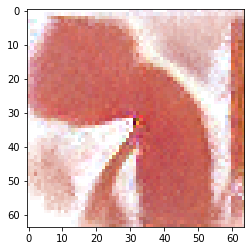

Epoch 2152, Loss: 3.939275026321411
Epoch 2153, Loss: 4.428892135620117
Epoch 2154, Loss: 4.415053844451904
Epoch 2155, Loss: 4.354852676391602
Epoch 2156, Loss: 3.8724920749664307
Epoch 2157, Loss: 3.781018018722534
Epoch 2158, Loss: 4.503666400909424
Epoch 2159, Loss: 3.739960193634033
Epoch 2160, Loss: 3.8177576065063477
Epoch 2161, Loss: 3.792287826538086
Epoch 2162, Loss: 3.298372745513916
Epoch 2163, Loss: 4.5069780349731445
Epoch 2164, Loss: 3.7739317417144775
Epoch 2165, Loss: 3.581517457962036
Epoch 2166, Loss: 3.7724549770355225
Epoch 2167, Loss: 4.778009414672852
Epoch 2168, Loss: 4.524328708648682
Epoch 2169, Loss: 5.485179424285889
Epoch 2170, Loss: 4.182631492614746
Epoch 2171, Loss: 3.7592782974243164
Epoch 2172, Loss: 3.902339458465576
Epoch 2173, Loss: 4.018060207366943
Epoch 2174, Loss: 3.5705366134643555
Epoch 2175, Loss: 5.01312255859375


Epoch 2176, Loss: 4.348790645599365


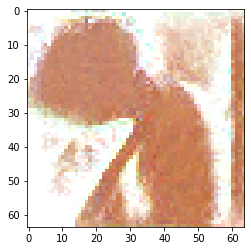

Epoch 2177, Loss: 4.175441741943359
Epoch 2178, Loss: 3.6867268085479736
Epoch 2179, Loss: 4.331057071685791
Epoch 2180, Loss: 3.9790987968444824
Epoch 2181, Loss: 3.8231301307678223
Epoch 2182, Loss: 3.7179808616638184
Epoch 2183, Loss: 4.543482303619385
Epoch 2184, Loss: 3.7016663551330566
Epoch 2185, Loss: 4.060478687286377
Epoch 2186, Loss: 3.980724573135376
Epoch 2187, Loss: 4.424137115478516
Epoch 2188, Loss: 3.638882637023926
Epoch 2189, Loss: 4.235462188720703
Epoch 2190, Loss: 3.887643337249756
Epoch 2191, Loss: 3.9085958003997803
Epoch 2192, Loss: 3.9798665046691895
Epoch 2193, Loss: 4.730396747589111
Epoch 2194, Loss: 3.8950719833374023
Epoch 2195, Loss: 3.750012159347534
Epoch 2196, Loss: 3.5850749015808105
Epoch 2197, Loss: 3.7350659370422363
Epoch 2198, Loss: 4.010124206542969
Epoch 2199, Loss: 4.12270450592041
Epoch 2200, Loss: 4.4527812004089355


Epoch 2201, Loss: 3.796628475189209


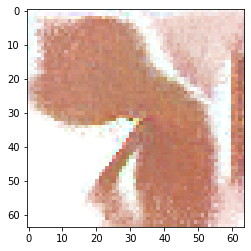

Epoch 2202, Loss: 4.304983139038086
Epoch 2203, Loss: 3.9514639377593994
Epoch 2204, Loss: 5.123275279998779
Epoch 2205, Loss: 5.142265319824219
Epoch 2206, Loss: 4.661061763763428
Epoch 2207, Loss: 3.7319793701171875
Epoch 2208, Loss: 4.479245662689209
Epoch 2209, Loss: 3.7802393436431885
Epoch 2210, Loss: 4.003508567810059
Epoch 2211, Loss: 3.9827427864074707
Epoch 2212, Loss: 4.707211017608643
Epoch 2213, Loss: 3.6814064979553223
Epoch 2214, Loss: 4.018472671508789
Epoch 2215, Loss: 4.261362075805664
Epoch 2216, Loss: 3.726421594619751
Epoch 2217, Loss: 3.498004674911499
Epoch 2218, Loss: 3.4737579822540283
Epoch 2219, Loss: 3.8101162910461426
Epoch 2220, Loss: 4.3090715408325195
Epoch 2221, Loss: 3.432255268096924
Epoch 2222, Loss: 3.9378721714019775
Epoch 2223, Loss: 3.9964005947113037
Epoch 2224, Loss: 4.0128021240234375
Epoch 2225, Loss: 4.998311996459961


Epoch 2226, Loss: 4.495144844055176


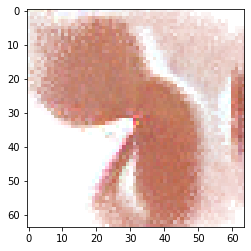

Epoch 2227, Loss: 5.077676773071289
Epoch 2228, Loss: 4.632199764251709
Epoch 2229, Loss: 3.6945126056671143
Epoch 2230, Loss: 3.7699785232543945
Epoch 2231, Loss: 3.9769887924194336
Epoch 2232, Loss: 3.7622921466827393
Epoch 2233, Loss: 4.095425128936768
Epoch 2234, Loss: 3.773066520690918
Epoch 2235, Loss: 4.766579627990723
Epoch 2236, Loss: 3.650269031524658
Epoch 2237, Loss: 4.103886127471924
Epoch 2238, Loss: 3.539951801300049
Epoch 2239, Loss: 3.694789409637451
Epoch 2240, Loss: 3.994990110397339
Epoch 2241, Loss: 3.4019603729248047
Epoch 2242, Loss: 3.3221232891082764
Epoch 2243, Loss: 3.58596134185791
Epoch 2244, Loss: 3.34059739112854
Epoch 2245, Loss: 4.590912342071533
Epoch 2246, Loss: 3.4156665802001953
Epoch 2247, Loss: 3.395311117172241
Epoch 2248, Loss: 3.5583834648132324
Epoch 2249, Loss: 3.057032823562622
Epoch 2250, Loss: 3.2529540061950684


Epoch 2251, Loss: 4.067261695861816


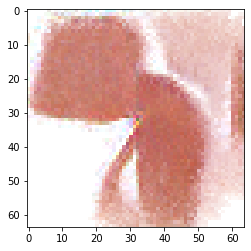

Epoch 2252, Loss: 3.3414206504821777
Epoch 2253, Loss: 3.528726577758789
Epoch 2254, Loss: 3.5444014072418213
Epoch 2255, Loss: 3.570864677429199
Epoch 2256, Loss: 3.9694619178771973
Epoch 2257, Loss: 3.2874836921691895
Epoch 2258, Loss: 3.901970386505127
Epoch 2259, Loss: 3.180551052093506
Epoch 2260, Loss: 4.416409969329834
Epoch 2261, Loss: 3.326063632965088
Epoch 2262, Loss: 3.6908817291259766
Epoch 2263, Loss: 4.48319149017334
Epoch 2264, Loss: 3.472505807876587
Epoch 2265, Loss: 3.276069402694702
Epoch 2266, Loss: 4.43934965133667
Epoch 2267, Loss: 2.986143112182617
Epoch 2268, Loss: 5.83626651763916
Epoch 2269, Loss: 3.59299373626709
Epoch 2270, Loss: 3.626110792160034
Epoch 2271, Loss: 3.1096298694610596
Epoch 2272, Loss: 3.181286096572876
Epoch 2273, Loss: 3.1906578540802
Epoch 2274, Loss: 3.464506149291992
Epoch 2275, Loss: 3.8400206565856934


Epoch 2276, Loss: 3.3850741386413574


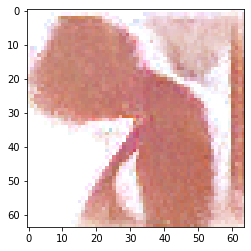

Epoch 2277, Loss: 3.699241876602173
Epoch 2278, Loss: 3.578303098678589
Epoch 2279, Loss: 4.269707202911377
Epoch 2280, Loss: 4.309001445770264
Epoch 2281, Loss: 5.038397312164307
Epoch 2282, Loss: 3.7977232933044434
Epoch 2283, Loss: 3.770334005355835
Epoch 2284, Loss: 5.00039005279541
Epoch 2285, Loss: 3.8041884899139404
Epoch 2286, Loss: 3.321953773498535
Epoch 2287, Loss: 4.225548267364502
Epoch 2288, Loss: 3.8266475200653076
Epoch 2289, Loss: 3.8403377532958984
Epoch 2290, Loss: 3.6951043605804443
Epoch 2291, Loss: 3.8116984367370605
Epoch 2292, Loss: 3.620455503463745
Epoch 2293, Loss: 3.6563527584075928
Epoch 2294, Loss: 3.812668561935425
Epoch 2295, Loss: 3.5853028297424316
Epoch 2296, Loss: 4.153165817260742
Epoch 2297, Loss: 4.180901527404785
Epoch 2298, Loss: 3.4107651710510254
Epoch 2299, Loss: 3.39589262008667
Epoch 2300, Loss: 3.1461668014526367


Epoch 2301, Loss: 3.303675651550293


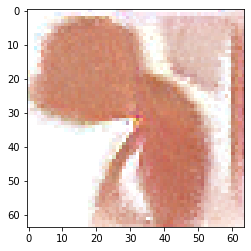

Epoch 2302, Loss: 3.5670254230499268
Epoch 2303, Loss: 3.189659595489502
Epoch 2304, Loss: 3.4022159576416016
Epoch 2305, Loss: 3.7660934925079346
Epoch 2306, Loss: 4.442616939544678
Epoch 2307, Loss: 3.2311792373657227
Epoch 2308, Loss: 3.8820066452026367
Epoch 2309, Loss: 3.36910343170166
Epoch 2310, Loss: 3.7945291996002197
Epoch 2311, Loss: 3.3148884773254395
Epoch 2312, Loss: 3.8716461658477783
Epoch 2313, Loss: 3.154416799545288
Epoch 2314, Loss: 3.4841320514678955
Epoch 2315, Loss: 3.982478380203247
Epoch 2316, Loss: 3.651010274887085
Epoch 2317, Loss: 4.90240478515625
Epoch 2318, Loss: 4.065384864807129
Epoch 2319, Loss: 4.273684501647949
Epoch 2320, Loss: 3.9411277770996094
Epoch 2321, Loss: 3.629490852355957
Epoch 2322, Loss: 3.454133987426758
Epoch 2323, Loss: 3.7473864555358887
Epoch 2324, Loss: 3.98939847946167
Epoch 2325, Loss: 4.530459403991699


Epoch 2326, Loss: 4.443637847900391


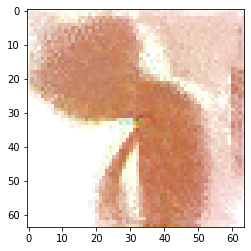

Epoch 2327, Loss: 3.846172332763672
Epoch 2328, Loss: 3.9929263591766357
Epoch 2329, Loss: 3.399705410003662
Epoch 2330, Loss: 4.160760879516602
Epoch 2331, Loss: 4.269845008850098
Epoch 2332, Loss: 3.544066905975342
Epoch 2333, Loss: 3.6686136722564697
Epoch 2334, Loss: 3.6759204864501953
Epoch 2335, Loss: 3.4229483604431152
Epoch 2336, Loss: 3.351933240890503
Epoch 2337, Loss: 3.164052963256836
Epoch 2338, Loss: 3.139695167541504
Epoch 2339, Loss: 3.4012556076049805
Epoch 2340, Loss: 3.4389355182647705
Epoch 2341, Loss: 3.3474814891815186
Epoch 2342, Loss: 3.2106447219848633
Epoch 2343, Loss: 3.2968335151672363
Epoch 2344, Loss: 4.044072151184082
Epoch 2345, Loss: 3.284616470336914
Epoch 2346, Loss: 3.257646083831787
Epoch 2347, Loss: 3.3043627738952637
Epoch 2348, Loss: 3.1863982677459717
Epoch 2349, Loss: 3.6979615688323975
Epoch 2350, Loss: 3.3334805965423584


Epoch 2351, Loss: 3.8132739067077637


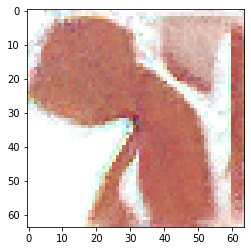

Epoch 2352, Loss: 3.113687515258789
Epoch 2353, Loss: 2.978463888168335
Epoch 2354, Loss: 3.5124056339263916
Epoch 2355, Loss: 3.550985097885132
Epoch 2356, Loss: 3.2865796089172363
Epoch 2357, Loss: 3.0830814838409424
Epoch 2358, Loss: 3.10062575340271
Epoch 2359, Loss: 3.1612775325775146
Epoch 2360, Loss: 5.721827507019043
Epoch 2361, Loss: 3.577463388442993
Epoch 2362, Loss: 3.39401912689209
Epoch 2363, Loss: 4.698810577392578
Epoch 2364, Loss: 3.2520554065704346
Epoch 2365, Loss: 5.234317779541016
Epoch 2366, Loss: 5.041239261627197
Epoch 2367, Loss: 3.6800265312194824
Epoch 2368, Loss: 3.4330201148986816
Epoch 2369, Loss: 3.7393603324890137
Epoch 2370, Loss: 3.8292548656463623
Epoch 2371, Loss: 3.5848758220672607
Epoch 2372, Loss: 3.9399869441986084
Epoch 2373, Loss: 3.315025568008423
Epoch 2374, Loss: 3.8120594024658203
Epoch 2375, Loss: 3.3358473777770996


Epoch 2376, Loss: 3.5687525272369385


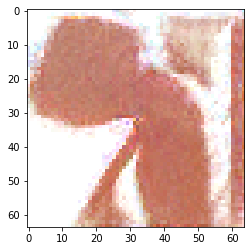

Epoch 2377, Loss: 3.387331247329712
Epoch 2378, Loss: 3.4636247158050537
Epoch 2379, Loss: 5.598636627197266
Epoch 2380, Loss: 3.8281521797180176
Epoch 2381, Loss: 4.055999755859375
Epoch 2382, Loss: 4.830277919769287
Epoch 2383, Loss: 3.604621410369873
Epoch 2384, Loss: 3.8056082725524902
Epoch 2385, Loss: 3.3245689868927
Epoch 2386, Loss: 3.857750415802002
Epoch 2387, Loss: 4.055238723754883
Epoch 2388, Loss: 3.513608455657959
Epoch 2389, Loss: 3.247938632965088
Epoch 2390, Loss: 3.2761621475219727
Epoch 2391, Loss: 3.738332986831665
Epoch 2392, Loss: 4.500150203704834
Epoch 2393, Loss: 4.043324947357178
Epoch 2394, Loss: 3.9684202671051025
Epoch 2395, Loss: 3.5531704425811768
Epoch 2396, Loss: 3.8765110969543457
Epoch 2397, Loss: 4.197801113128662
Epoch 2398, Loss: 4.250848770141602
Epoch 2399, Loss: 3.701282262802124
Epoch 2400, Loss: 4.342012405395508


Epoch 2401, Loss: 3.630662441253662


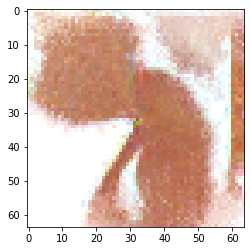

Epoch 2402, Loss: 3.795867443084717
Epoch 2403, Loss: 4.223333358764648
Epoch 2404, Loss: 4.2119622230529785
Epoch 2405, Loss: 3.8258233070373535
Epoch 2406, Loss: 3.4887142181396484
Epoch 2407, Loss: 4.621777057647705
Epoch 2408, Loss: 3.8162589073181152
Epoch 2409, Loss: 3.7423524856567383
Epoch 2410, Loss: 3.6648809909820557
Epoch 2411, Loss: 3.594048023223877
Epoch 2412, Loss: 3.640920400619507
Epoch 2413, Loss: 3.467878818511963
Epoch 2414, Loss: 3.384009838104248
Epoch 2415, Loss: 3.5240979194641113
Epoch 2416, Loss: 3.6138434410095215
Epoch 2417, Loss: 3.900428056716919
Epoch 2418, Loss: 4.072166442871094
Epoch 2419, Loss: 5.067194938659668
Epoch 2420, Loss: 4.075686454772949
Epoch 2421, Loss: 5.326621055603027
Epoch 2422, Loss: 4.156930446624756
Epoch 2423, Loss: 4.541841983795166
Epoch 2424, Loss: 3.897904872894287
Epoch 2425, Loss: 4.124402046203613


Epoch 2426, Loss: 4.120155334472656


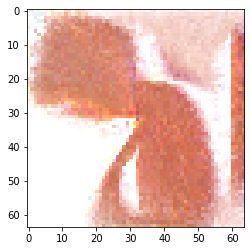

Epoch 2427, Loss: 5.304729461669922
Epoch 2428, Loss: 4.810515403747559
Epoch 2429, Loss: 4.612400054931641
Epoch 2430, Loss: 4.590630531311035
Epoch 2431, Loss: 4.494289398193359
Epoch 2432, Loss: 4.780801296234131
Epoch 2433, Loss: 4.305559158325195
Epoch 2434, Loss: 4.127559661865234
Epoch 2435, Loss: 7.616694927215576
Epoch 2436, Loss: 4.814003944396973
Epoch 2437, Loss: 4.073860168457031
Epoch 2438, Loss: 3.8895316123962402
Epoch 2439, Loss: 5.610443115234375
Epoch 2440, Loss: 4.464964389801025
Epoch 2441, Loss: 4.22433614730835
Epoch 2442, Loss: 4.817134857177734
Epoch 2443, Loss: 3.9360475540161133
Epoch 2444, Loss: 4.181931972503662
Epoch 2445, Loss: 4.026148319244385
Epoch 2446, Loss: 3.591268539428711
Epoch 2447, Loss: 3.57167649269104
Epoch 2448, Loss: 4.878495693206787
Epoch 2449, Loss: 4.905003070831299
Epoch 2450, Loss: 3.905639171600342


Epoch 2451, Loss: 4.021979331970215


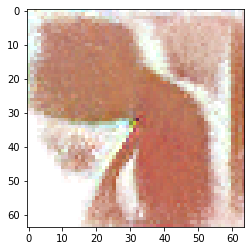

Epoch 2452, Loss: 3.404388666152954
Epoch 2453, Loss: 4.733096599578857
Epoch 2454, Loss: 4.072939395904541
Epoch 2455, Loss: 3.4656033515930176
Epoch 2456, Loss: 3.4780702590942383
Epoch 2457, Loss: 3.2135908603668213
Epoch 2458, Loss: 5.058495044708252
Epoch 2459, Loss: 3.902536153793335
Epoch 2460, Loss: 3.1288602352142334
Epoch 2461, Loss: 3.173562526702881
Epoch 2462, Loss: 5.9947123527526855
Epoch 2463, Loss: 3.2710659503936768
Epoch 2464, Loss: 4.436657905578613
Epoch 2465, Loss: 4.908269882202148
Epoch 2466, Loss: 4.427165508270264
Epoch 2467, Loss: 4.084471225738525
Epoch 2468, Loss: 4.316235542297363
Epoch 2469, Loss: 4.4821391105651855
Epoch 2470, Loss: 4.703795433044434
Epoch 2471, Loss: 4.409632205963135
Epoch 2472, Loss: 3.7840652465820312
Epoch 2473, Loss: 4.246116638183594
Epoch 2474, Loss: 4.430348873138428
Epoch 2475, Loss: 3.734527111053467


Epoch 2476, Loss: 3.6515276432037354


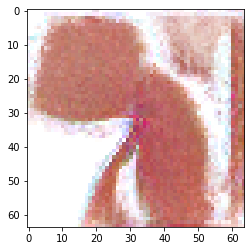

Epoch 2477, Loss: 5.1839752197265625
Epoch 2478, Loss: 3.7130589485168457
Epoch 2479, Loss: 3.637047052383423
Epoch 2480, Loss: 3.705954074859619
Epoch 2481, Loss: 3.6661438941955566
Epoch 2482, Loss: 3.1289498805999756
Epoch 2483, Loss: 3.9623897075653076
Epoch 2484, Loss: 3.2944817543029785
Epoch 2485, Loss: 3.292896270751953
Epoch 2486, Loss: 3.1080644130706787
Epoch 2487, Loss: 4.795338153839111
Epoch 2488, Loss: 3.749133586883545
Epoch 2489, Loss: 3.2345592975616455
Epoch 2490, Loss: 2.9566237926483154
Epoch 2491, Loss: 3.251755952835083
Epoch 2492, Loss: 3.195478677749634
Epoch 2493, Loss: 3.4015893936157227
Epoch 2494, Loss: 3.0543036460876465
Epoch 2495, Loss: 3.102766752243042
Epoch 2496, Loss: 2.942657709121704
Epoch 2497, Loss: 3.785489797592163
Epoch 2498, Loss: 3.5375401973724365
Epoch 2499, Loss: 3.441166877746582
Epoch 2500, Loss: 3.7228844165802


Epoch 2501, Loss: 3.6987810134887695


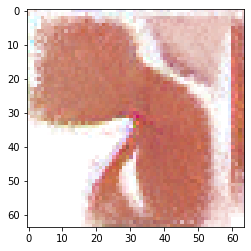

Epoch 2502, Loss: 4.239579200744629
Epoch 2503, Loss: 4.0098652839660645
Epoch 2504, Loss: 3.4471797943115234
Epoch 2505, Loss: 3.9223968982696533
Epoch 2506, Loss: 3.6011648178100586
Epoch 2507, Loss: 4.07954740524292
Epoch 2508, Loss: 3.5695459842681885
Epoch 2509, Loss: 3.522562265396118
Epoch 2510, Loss: 3.0393712520599365
Epoch 2511, Loss: 3.2321977615356445
Epoch 2512, Loss: 3.2390804290771484
Epoch 2513, Loss: 3.0539896488189697
Epoch 2514, Loss: 3.1716134548187256
Epoch 2515, Loss: 3.662907600402832
Epoch 2516, Loss: 3.1920166015625
Epoch 2517, Loss: 3.771641492843628
Epoch 2518, Loss: 3.04416561126709
Epoch 2519, Loss: 2.842808485031128
Epoch 2520, Loss: 3.1866390705108643
Epoch 2521, Loss: 2.9166617393493652
Epoch 2522, Loss: 2.905632972717285
Epoch 2523, Loss: 2.7543516159057617
Epoch 2524, Loss: 3.8822762966156006
Epoch 2525, Loss: 2.787821054458618


Epoch 2526, Loss: 3.1399474143981934


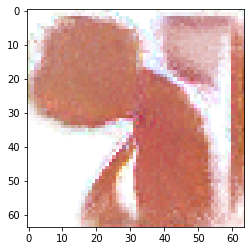

Epoch 2527, Loss: 3.5593457221984863
Epoch 2528, Loss: 3.6875884532928467
Epoch 2529, Loss: 3.0477309226989746
Epoch 2530, Loss: 4.1188836097717285
Epoch 2531, Loss: 3.2825005054473877
Epoch 2532, Loss: 3.075993537902832
Epoch 2533, Loss: 3.286363124847412
Epoch 2534, Loss: 4.796525001525879
Epoch 2535, Loss: 4.218754768371582
Epoch 2536, Loss: 4.015286922454834
Epoch 2537, Loss: 3.5105838775634766
Epoch 2538, Loss: 3.3340578079223633
Epoch 2539, Loss: 3.1664695739746094
Epoch 2540, Loss: 3.2330644130706787
Epoch 2541, Loss: 3.9333555698394775
Epoch 2542, Loss: 3.2550160884857178
Epoch 2543, Loss: 4.3414692878723145
Epoch 2544, Loss: 4.049714088439941
Epoch 2545, Loss: 3.448991537094116
Epoch 2546, Loss: 3.4802298545837402
Epoch 2547, Loss: 3.4772913455963135
Epoch 2548, Loss: 3.1656370162963867
Epoch 2549, Loss: 4.771428108215332
Epoch 2550, Loss: 3.0187363624572754


Epoch 2551, Loss: 2.8670010566711426


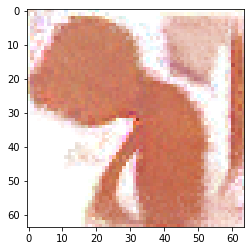

Epoch 2552, Loss: 3.4491047859191895
Epoch 2553, Loss: 3.0021731853485107
Epoch 2554, Loss: 3.2745134830474854
Epoch 2555, Loss: 3.1522233486175537
Epoch 2556, Loss: 5.129586696624756
Epoch 2557, Loss: 5.340183734893799
Epoch 2558, Loss: 5.576969623565674
Epoch 2559, Loss: 3.856623888015747
Epoch 2560, Loss: 3.7190935611724854
Epoch 2561, Loss: 3.5103518962860107
Epoch 2562, Loss: 4.1592278480529785
Epoch 2563, Loss: 3.7707395553588867
Epoch 2564, Loss: 3.269559860229492
Epoch 2565, Loss: 3.3551135063171387
Epoch 2566, Loss: 3.0900323390960693
Epoch 2567, Loss: 3.169646739959717
Epoch 2568, Loss: 3.243382215499878
Epoch 2569, Loss: 3.3367526531219482
Epoch 2570, Loss: 4.08652925491333
Epoch 2571, Loss: 3.659799575805664
Epoch 2572, Loss: 2.9787228107452393
Epoch 2573, Loss: 3.2372939586639404
Epoch 2574, Loss: 3.806445360183716
Epoch 2575, Loss: 3.2667882442474365


Epoch 2576, Loss: 3.2333779335021973


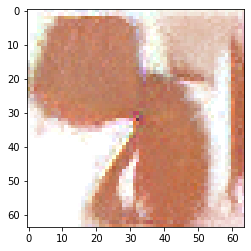

Epoch 2577, Loss: 3.7772574424743652
Epoch 2578, Loss: 3.8050875663757324
Epoch 2579, Loss: 3.5945568084716797
Epoch 2580, Loss: 3.866178512573242
Epoch 2581, Loss: 2.9909675121307373
Epoch 2582, Loss: 4.0326247215271
Epoch 2583, Loss: 3.5995237827301025
Epoch 2584, Loss: 3.2246313095092773
Epoch 2585, Loss: 3.532766819000244
Epoch 2586, Loss: 3.2115824222564697
Epoch 2587, Loss: 3.478024482727051
Epoch 2588, Loss: 3.5767312049865723
Epoch 2589, Loss: 3.585071086883545
Epoch 2590, Loss: 3.312908887863159
Epoch 2591, Loss: 3.466113567352295
Epoch 2592, Loss: 3.107945203781128
Epoch 2593, Loss: 3.268812894821167
Epoch 2594, Loss: 3.131120204925537
Epoch 2595, Loss: 3.8564250469207764
Epoch 2596, Loss: 3.301191806793213
Epoch 2597, Loss: 3.3560128211975098
Epoch 2598, Loss: 3.695770740509033
Epoch 2599, Loss: 2.989264488220215
Epoch 2600, Loss: 3.269296169281006


Epoch 2601, Loss: 3.4858696460723877


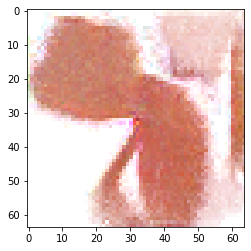

Epoch 2602, Loss: 4.224584102630615
Epoch 2603, Loss: 3.2272284030914307
Epoch 2604, Loss: 4.104846954345703
Epoch 2605, Loss: 3.300004720687866
Epoch 2606, Loss: 3.950547695159912
Epoch 2607, Loss: 3.3855020999908447
Epoch 2608, Loss: 4.212634086608887
Epoch 2609, Loss: 3.549619674682617
Epoch 2610, Loss: 3.593064546585083
Epoch 2611, Loss: 3.7153754234313965
Epoch 2612, Loss: 3.859861135482788
Epoch 2613, Loss: 3.545712947845459
Epoch 2614, Loss: 4.877068996429443
Epoch 2615, Loss: 3.3942103385925293
Epoch 2616, Loss: 3.304452419281006
Epoch 2617, Loss: 3.232126235961914
Epoch 2618, Loss: 3.207047939300537
Epoch 2619, Loss: 3.4770493507385254
Epoch 2620, Loss: 3.0591354370117188
Epoch 2621, Loss: 4.072972297668457
Epoch 2622, Loss: 2.9870986938476562
Epoch 2623, Loss: 3.750758647918701
Epoch 2624, Loss: 3.745090961456299
Epoch 2625, Loss: 3.4411630630493164


Epoch 2626, Loss: 3.123579502105713


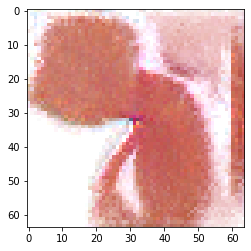

Epoch 2627, Loss: 4.0579447746276855
Epoch 2628, Loss: 3.6894547939300537
Epoch 2629, Loss: 3.734567642211914
Epoch 2630, Loss: 3.4392197132110596
Epoch 2631, Loss: 3.8447957038879395
Epoch 2632, Loss: 3.4357738494873047
Epoch 2633, Loss: 3.258469581604004
Epoch 2634, Loss: 3.5890705585479736
Epoch 2635, Loss: 3.217374801635742
Epoch 2636, Loss: 3.1835885047912598
Epoch 2637, Loss: 3.3432867527008057
Epoch 2638, Loss: 3.009920835494995
Epoch 2639, Loss: 3.239903688430786
Epoch 2640, Loss: 5.288313865661621
Epoch 2641, Loss: 4.9207868576049805
Epoch 2642, Loss: 3.452228307723999
Epoch 2643, Loss: 3.406700611114502
Epoch 2644, Loss: 3.253363847732544
Epoch 2645, Loss: 2.836042642593384
Epoch 2646, Loss: 3.2876710891723633
Epoch 2647, Loss: 2.790998935699463
Epoch 2648, Loss: 4.042842388153076
Epoch 2649, Loss: 2.9412410259246826
Epoch 2650, Loss: 4.712558269500732


Epoch 2651, Loss: 3.195251226425171


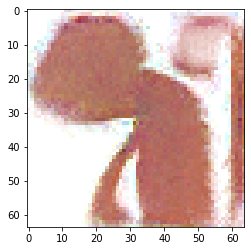

Epoch 2652, Loss: 3.2066867351531982
Epoch 2653, Loss: 3.2002971172332764
Epoch 2654, Loss: 3.2119553089141846
Epoch 2655, Loss: 3.4624979496002197
Epoch 2656, Loss: 4.590395450592041
Epoch 2657, Loss: 3.524766206741333
Epoch 2658, Loss: 3.6611053943634033
Epoch 2659, Loss: 3.2423417568206787
Epoch 2660, Loss: 3.5902693271636963
Epoch 2661, Loss: 3.654627799987793
Epoch 2662, Loss: 4.652990341186523
Epoch 2663, Loss: 3.5727922916412354
Epoch 2664, Loss: 3.631538152694702
Epoch 2665, Loss: 4.268023490905762
Epoch 2666, Loss: 3.5669844150543213
Epoch 2667, Loss: 4.147997856140137
Epoch 2668, Loss: 3.622269630432129
Epoch 2669, Loss: 3.885187864303589
Epoch 2670, Loss: 3.4438538551330566
Epoch 2671, Loss: 3.416172504425049
Epoch 2672, Loss: 3.1261749267578125
Epoch 2673, Loss: 2.9053165912628174
Epoch 2674, Loss: 3.438333749771118
Epoch 2675, Loss: 4.876289367675781


Epoch 2676, Loss: 3.0708060264587402


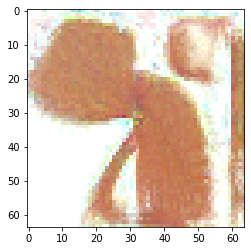

Epoch 2677, Loss: 2.7687013149261475
Epoch 2678, Loss: 3.4034557342529297
Epoch 2679, Loss: 3.177821636199951
Epoch 2680, Loss: 3.267883777618408
Epoch 2681, Loss: 4.693277835845947
Epoch 2682, Loss: 3.5821542739868164
Epoch 2683, Loss: 3.2848029136657715
Epoch 2684, Loss: 3.094672679901123
Epoch 2685, Loss: 4.598955154418945
Epoch 2686, Loss: 4.269335746765137
Epoch 2687, Loss: 4.0035176277160645
Epoch 2688, Loss: 3.2860119342803955
Epoch 2689, Loss: 3.7479498386383057
Epoch 2690, Loss: 3.282491445541382
Epoch 2691, Loss: 3.4522597789764404
Epoch 2692, Loss: 4.23011589050293
Epoch 2693, Loss: 4.35382604598999
Epoch 2694, Loss: 4.320041179656982
Epoch 2695, Loss: 4.3344902992248535
Epoch 2696, Loss: 4.62431001663208
Epoch 2697, Loss: 5.087283134460449
Epoch 2698, Loss: 4.013886451721191
Epoch 2699, Loss: 4.104921340942383
Epoch 2700, Loss: 3.916506052017212


Epoch 2701, Loss: 3.3823654651641846


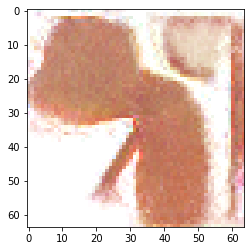

Epoch 2702, Loss: 6.130277156829834
Epoch 2703, Loss: 3.3933792114257812
Epoch 2704, Loss: 4.689999103546143
Epoch 2705, Loss: 3.2244913578033447
Epoch 2706, Loss: 3.4477155208587646
Epoch 2707, Loss: 3.4185283184051514
Epoch 2708, Loss: 5.1377997398376465
Epoch 2709, Loss: 4.683609962463379
Epoch 2710, Loss: 3.341888904571533
Epoch 2711, Loss: 3.7139196395874023
Epoch 2712, Loss: 3.285797357559204
Epoch 2713, Loss: 4.360377311706543
Epoch 2714, Loss: 3.553713083267212
Epoch 2715, Loss: 3.351172924041748
Epoch 2716, Loss: 3.397038221359253
Epoch 2717, Loss: 4.54891300201416
Epoch 2718, Loss: 3.5598673820495605
Epoch 2719, Loss: 3.3057405948638916
Epoch 2720, Loss: 3.183222532272339
Epoch 2721, Loss: 3.2529287338256836
Epoch 2722, Loss: 3.0882391929626465
Epoch 2723, Loss: 3.944230794906616
Epoch 2724, Loss: 3.461477518081665
Epoch 2725, Loss: 3.787959337234497


Epoch 2726, Loss: 3.7144155502319336


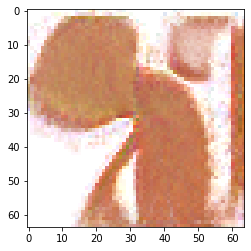

Epoch 2727, Loss: 3.3387451171875
Epoch 2728, Loss: 3.3009629249572754
Epoch 2729, Loss: 3.2326931953430176
Epoch 2730, Loss: 3.325309991836548
Epoch 2731, Loss: 4.45778226852417
Epoch 2732, Loss: 3.56209135055542
Epoch 2733, Loss: 3.846881628036499
Epoch 2734, Loss: 3.3407845497131348
Epoch 2735, Loss: 3.4317240715026855
Epoch 2736, Loss: 4.521461486816406
Epoch 2737, Loss: 3.923455238342285
Epoch 2738, Loss: 3.4170827865600586
Epoch 2739, Loss: 3.2337024211883545
Epoch 2740, Loss: 2.937180280685425
Epoch 2741, Loss: 3.378115177154541
Epoch 2742, Loss: 3.6095731258392334
Epoch 2743, Loss: 3.2792820930480957
Epoch 2744, Loss: 3.3361144065856934
Epoch 2745, Loss: 3.2956290245056152
Epoch 2746, Loss: 3.6751296520233154
Epoch 2747, Loss: 3.0961484909057617
Epoch 2748, Loss: 3.20485782623291
Epoch 2749, Loss: 3.2034900188446045
Epoch 2750, Loss: 2.854545831680298


Epoch 2751, Loss: 3.4675211906433105


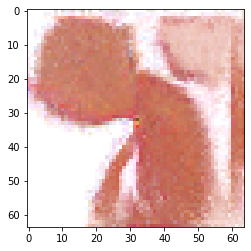

Epoch 2752, Loss: 3.1631932258605957
Epoch 2753, Loss: 2.8400630950927734
Epoch 2754, Loss: 3.8142435550689697
Epoch 2755, Loss: 3.0904362201690674
Epoch 2756, Loss: 3.399840831756592
Epoch 2757, Loss: 3.248098373413086
Epoch 2758, Loss: 3.624103546142578
Epoch 2759, Loss: 3.373706817626953
Epoch 2760, Loss: 3.405247211456299
Epoch 2761, Loss: 2.9801619052886963
Epoch 2762, Loss: 2.9153525829315186
Epoch 2763, Loss: 3.262233018875122
Epoch 2764, Loss: 3.930206298828125
Epoch 2765, Loss: 3.2772719860076904
Epoch 2766, Loss: 3.2804064750671387
Epoch 2767, Loss: 3.281541109085083
Epoch 2768, Loss: 3.324108839035034
Epoch 2769, Loss: 3.0518527030944824
Epoch 2770, Loss: 2.8909878730773926
Epoch 2771, Loss: 3.2985925674438477
Epoch 2772, Loss: 3.6295504570007324
Epoch 2773, Loss: 3.4654505252838135
Epoch 2774, Loss: 3.1688201427459717
Epoch 2775, Loss: 2.8225574493408203


Epoch 2776, Loss: 3.002443790435791


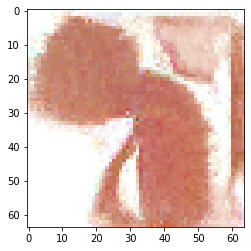

Epoch 2777, Loss: 3.0864481925964355
Epoch 2778, Loss: 3.254807710647583
Epoch 2779, Loss: 3.152114152908325
Epoch 2780, Loss: 4.357050895690918
Epoch 2781, Loss: 3.059558391571045
Epoch 2782, Loss: 2.9341683387756348
Epoch 2783, Loss: 3.5791971683502197
Epoch 2784, Loss: 3.1362063884735107
Epoch 2785, Loss: 3.501246213912964
Epoch 2786, Loss: 3.077146053314209
Epoch 2787, Loss: 3.043609142303467
Epoch 2788, Loss: 3.00862455368042
Epoch 2789, Loss: 3.1659343242645264
Epoch 2790, Loss: 4.19138765335083
Epoch 2791, Loss: 3.1362693309783936
Epoch 2792, Loss: 4.402923107147217
Epoch 2793, Loss: 3.5754377841949463
Epoch 2794, Loss: 3.1492323875427246
Epoch 2795, Loss: 3.170292377471924
Epoch 2796, Loss: 2.8284289836883545
Epoch 2797, Loss: 3.203564405441284
Epoch 2798, Loss: 4.3593974113464355
Epoch 2799, Loss: 3.985515594482422
Epoch 2800, Loss: 3.028172731399536


Epoch 2801, Loss: 3.640798568725586


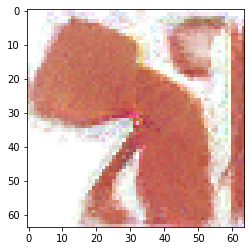

Epoch 2802, Loss: 3.747210741043091
Epoch 2803, Loss: 3.5461573600769043
Epoch 2804, Loss: 3.3906259536743164
Epoch 2805, Loss: 3.525447368621826
Epoch 2806, Loss: 3.3137197494506836
Epoch 2807, Loss: 3.461362361907959
Epoch 2808, Loss: 3.0396745204925537
Epoch 2809, Loss: 3.0596213340759277
Epoch 2810, Loss: 3.213657855987549
Epoch 2811, Loss: 5.131330966949463
Epoch 2812, Loss: 3.2867486476898193
Epoch 2813, Loss: 2.990314483642578
Epoch 2814, Loss: 2.9576027393341064
Epoch 2815, Loss: 4.358006954193115
Epoch 2816, Loss: 3.039660692214966
Epoch 2817, Loss: 3.0447397232055664
Epoch 2818, Loss: 3.1890463829040527
Epoch 2819, Loss: 5.146681308746338
Epoch 2820, Loss: 2.8360705375671387
Epoch 2821, Loss: 3.0712523460388184
Epoch 2822, Loss: 3.081801176071167
Epoch 2823, Loss: 3.3018908500671387
Epoch 2824, Loss: 3.243091344833374
Epoch 2825, Loss: 2.6363637447357178


Epoch 2826, Loss: 2.6663296222686768


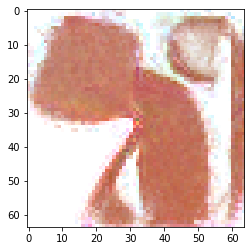

Epoch 2827, Loss: 2.934992551803589
Epoch 2828, Loss: 3.266437292098999
Epoch 2829, Loss: 2.8041110038757324
Epoch 2830, Loss: 2.7228102684020996
Epoch 2831, Loss: 2.8106157779693604
Epoch 2832, Loss: 4.9162917137146
Epoch 2833, Loss: 2.7571911811828613
Epoch 2834, Loss: 3.959652900695801
Epoch 2835, Loss: 3.464726448059082
Epoch 2836, Loss: 3.965190887451172
Epoch 2837, Loss: 3.6584880352020264
Epoch 2838, Loss: 3.748114824295044
Epoch 2839, Loss: 3.153613567352295
Epoch 2840, Loss: 3.4037790298461914
Epoch 2841, Loss: 3.60264253616333
Epoch 2842, Loss: 3.23075008392334
Epoch 2843, Loss: 3.1539769172668457
Epoch 2844, Loss: 3.197795867919922
Epoch 2845, Loss: 3.1387712955474854
Epoch 2846, Loss: 3.009270191192627
Epoch 2847, Loss: 3.6762378215789795
Epoch 2848, Loss: 2.5976924896240234
Epoch 2849, Loss: 2.960388422012329
Epoch 2850, Loss: 3.4854679107666016


Epoch 2851, Loss: 2.9687612056732178


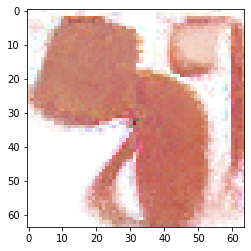

Epoch 2852, Loss: 3.964526891708374
Epoch 2853, Loss: 2.8268628120422363
Epoch 2854, Loss: 4.570296764373779
Epoch 2855, Loss: 5.450887203216553
Epoch 2856, Loss: 3.6595265865325928
Epoch 2857, Loss: 3.019139051437378
Epoch 2858, Loss: 3.263174057006836
Epoch 2859, Loss: 3.3142733573913574
Epoch 2860, Loss: 3.172126293182373
Epoch 2861, Loss: 3.823159694671631
Epoch 2862, Loss: 3.0005173683166504
Epoch 2863, Loss: 3.4726505279541016
Epoch 2864, Loss: 3.045285701751709
Epoch 2865, Loss: 3.1228601932525635
Epoch 2866, Loss: 3.454296350479126
Epoch 2867, Loss: 3.3717586994171143
Epoch 2868, Loss: 3.3072750568389893
Epoch 2869, Loss: 4.208041667938232
Epoch 2870, Loss: 2.92397403717041
Epoch 2871, Loss: 2.9015564918518066
Epoch 2872, Loss: 2.8062381744384766
Epoch 2873, Loss: 3.7589588165283203
Epoch 2874, Loss: 3.3379905223846436
Epoch 2875, Loss: 3.155364751815796


Epoch 2876, Loss: 3.373717784881592


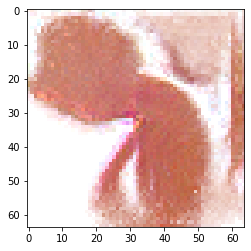

Epoch 2877, Loss: 3.1684253215789795
Epoch 2878, Loss: 2.8520843982696533
Epoch 2879, Loss: 2.915412664413452
Epoch 2880, Loss: 2.8055155277252197
Epoch 2881, Loss: 3.237421751022339
Epoch 2882, Loss: 3.638535737991333
Epoch 2883, Loss: 2.939155101776123
Epoch 2884, Loss: 2.943063735961914
Epoch 2885, Loss: 3.525270462036133
Epoch 2886, Loss: 3.42111873626709
Epoch 2887, Loss: 3.30665922164917
Epoch 2888, Loss: 3.2059102058410645
Epoch 2889, Loss: 3.941018581390381
Epoch 2890, Loss: 3.6235272884368896
Epoch 2891, Loss: 3.1844065189361572
Epoch 2892, Loss: 3.3161098957061768
Epoch 2893, Loss: 2.7792439460754395
Epoch 2894, Loss: 3.091940402984619
Epoch 2895, Loss: 3.2580347061157227
Epoch 2896, Loss: 3.5895466804504395
Epoch 2897, Loss: 3.6272850036621094
Epoch 2898, Loss: 3.017601251602173
Epoch 2899, Loss: 3.4050800800323486
Epoch 2900, Loss: 3.3304686546325684


Epoch 2901, Loss: 3.3329732418060303


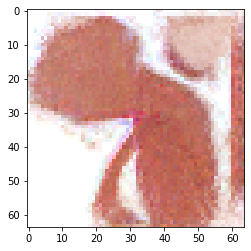

Epoch 2902, Loss: 3.2928335666656494
Epoch 2903, Loss: 3.1986734867095947
Epoch 2904, Loss: 3.4595999717712402
Epoch 2905, Loss: 4.294876575469971
Epoch 2906, Loss: 3.967434883117676
Epoch 2907, Loss: 3.3786230087280273
Epoch 2908, Loss: 3.4074976444244385
Epoch 2909, Loss: 3.7617523670196533
Epoch 2910, Loss: 3.748689651489258
Epoch 2911, Loss: 3.296016216278076
Epoch 2912, Loss: 3.5775012969970703
Epoch 2913, Loss: 3.4108548164367676
Epoch 2914, Loss: 3.599543571472168
Epoch 2915, Loss: 3.3293590545654297
Epoch 2916, Loss: 3.062817096710205
Epoch 2917, Loss: 3.551579236984253
Epoch 2918, Loss: 3.3282980918884277
Epoch 2919, Loss: 2.822232961654663
Epoch 2920, Loss: 3.581716537475586
Epoch 2921, Loss: 3.094666004180908
Epoch 2922, Loss: 3.2893474102020264
Epoch 2923, Loss: 3.0091588497161865
Epoch 2924, Loss: 3.763455867767334
Epoch 2925, Loss: 3.231659412384033


Epoch 2926, Loss: 3.0779805183410645


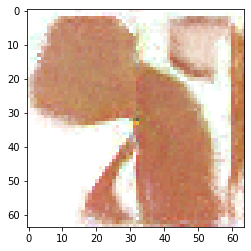

Epoch 2927, Loss: 2.602947473526001
Epoch 2928, Loss: 3.2325267791748047
Epoch 2929, Loss: 3.138493061065674
Epoch 2930, Loss: 4.5563554763793945
Epoch 2931, Loss: 2.789555788040161
Epoch 2932, Loss: 2.830852746963501
Epoch 2933, Loss: 3.280467987060547
Epoch 2934, Loss: 2.9607958793640137
Epoch 2935, Loss: 3.112396001815796
Epoch 2936, Loss: 4.021233558654785
Epoch 2937, Loss: 4.049370288848877
Epoch 2938, Loss: 3.4298136234283447
Epoch 2939, Loss: 3.7301859855651855
Epoch 2940, Loss: 3.4851181507110596
Epoch 2941, Loss: 3.5442612171173096
Epoch 2942, Loss: 3.396268606185913
Epoch 2943, Loss: 3.10221791267395
Epoch 2944, Loss: 3.154919385910034
Epoch 2945, Loss: 2.6412196159362793
Epoch 2946, Loss: 3.0400407314300537
Epoch 2947, Loss: 3.397207260131836
Epoch 2948, Loss: 3.8370862007141113
Epoch 2949, Loss: 3.005051612854004
Epoch 2950, Loss: 2.9643309116363525


Epoch 2951, Loss: 2.7156379222869873


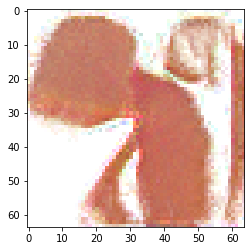

Epoch 2952, Loss: 2.892857074737549
Epoch 2953, Loss: 2.8148512840270996
Epoch 2954, Loss: 2.814826011657715
Epoch 2955, Loss: 3.4917078018188477
Epoch 2956, Loss: 3.1733431816101074
Epoch 2957, Loss: 3.7375025749206543
Epoch 2958, Loss: 2.8088412284851074
Epoch 2959, Loss: 3.0328376293182373
Epoch 2960, Loss: 3.2349352836608887
Epoch 2961, Loss: 3.865463972091675
Epoch 2962, Loss: 3.6237783432006836
Epoch 2963, Loss: 3.5943691730499268
Epoch 2964, Loss: 3.6637372970581055
Epoch 2965, Loss: 3.3457624912261963
Epoch 2966, Loss: 4.009791374206543
Epoch 2967, Loss: 3.5152010917663574
Epoch 2968, Loss: 3.3268251419067383
Epoch 2969, Loss: 3.278514862060547
Epoch 2970, Loss: 3.3299155235290527
Epoch 2971, Loss: 3.376600980758667
Epoch 2972, Loss: 4.092212200164795
Epoch 2973, Loss: 3.0902888774871826
Epoch 2974, Loss: 3.074779987335205
Epoch 2975, Loss: 2.8576786518096924


Epoch 2976, Loss: 3.5567119121551514


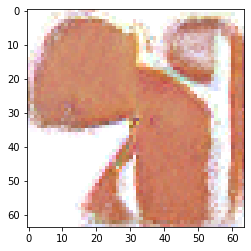

Epoch 2977, Loss: 2.5406899452209473
Epoch 2978, Loss: 2.886150360107422
Epoch 2979, Loss: 2.989630699157715
Epoch 2980, Loss: 2.991231679916382
Epoch 2981, Loss: 3.5008456707000732
Epoch 2982, Loss: 3.619846820831299
Epoch 2983, Loss: 3.288412094116211
Epoch 2984, Loss: 3.2535250186920166
Epoch 2985, Loss: 3.8175575733184814
Epoch 2986, Loss: 3.4407217502593994
Epoch 2987, Loss: 3.6068804264068604
Epoch 2988, Loss: 3.2936573028564453
Epoch 2989, Loss: 3.0545461177825928
Epoch 2990, Loss: 4.164880275726318
Epoch 2991, Loss: 3.0973706245422363
Epoch 2992, Loss: 3.2664008140563965
Epoch 2993, Loss: 3.3356995582580566
Epoch 2994, Loss: 3.552399158477783
Epoch 2995, Loss: 3.1165707111358643
Epoch 2996, Loss: 3.696134567260742
Epoch 2997, Loss: 2.7613587379455566
Epoch 2998, Loss: 4.432852745056152
Epoch 2999, Loss: 3.5400986671447754
Epoch 3000, Loss: 3.251473903656006


In [ ]:
EPOCHS = 500
for epoch in range(EPOCHS):
    x, loss = train_step(x0)
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch + 1, loss))

    if epoch % 25 == 0:
        plot(x)

In [ ]:
model.save("testModel")

In [ ]:
#@title TensorFlow.js Demo {run:"auto", vertical-output: true}
#@markdown Select "CHECKPOINT" model to load the checkpoint created by running cells from the "Training" section of this notebook
import IPython.display

data_js = '''
  window.GRAPH_URL = URL.createObjectURL(new Blob([`%s`], {type: 'application/json'}));
'''%(model)

display(IPython.display.Javascript(data_js))

IPython.display.HTML('''
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@2.3.0/dist/tf.min.js"></script>

<canvas id='canvas' style="border: 1px solid black; image-rendering: pixelated;"></canvas>

<script>
  "use strict";
  
  const sleep = (ms)=>new Promise(resolve => setTimeout(resolve, ms));

  const parseConsts = model_graph=>{
    const dtypes = {'DT_INT32':['int32', 'intVal', Int32Array],
                    'DT_FLOAT':['float32', 'floatVal', Float32Array]};
    
    const consts = {};
    model_graph.modelTopology.node.filter(n=>n.op=='Const').forEach((node=>{
      const v = node.attr.value.tensor;
      const [dtype, field, arrayType] = dtypes[v.dtype];
      if (!v.tensorShape.dim) {
        consts[node.name] = [tf.scalar(v[field][0], dtype)];
      } else {
        // if there is a 0-length dimension, the exported graph json lacks "size"
        const shape = v.tensorShape.dim.map(d=>(!d.size) ? 0 : parseInt(d.size));
        let arr;
        if (v.tensorContent) {
          const data = atob(v.tensorContent);
          const buf = new Uint8Array(data.length);
          for (var i=0; i<data.length; ++i) {
            buf[i] = data.charCodeAt(i);
          }
          arr = new arrayType(buf.buffer);
        } else {
          const size = shape.reduce((a, b)=>a*b);
          arr = new arrayType(size);
          if (size) {
            arr.fill(v[field][0]);
          }
        }
        consts[node.name] = [tf.tensor(arr, shape, dtype)];
      }
    }));
    return consts;
  }
  
  const run = async ()=>{
    const r = await fetch(GRAPH_URL);
    const consts = parseConsts(await r.json());
    
    const model = await tf.loadGraphModel(GRAPH_URL);
    Object.assign(model.weights, consts);
    
    let seed = new Array(16).fill(0).map((x, i)=>i<3?0:1);
    seed = tf.tensor(seed, [1, 1, 1, 16]);
    
    const D = 96;
    const initState = tf.tidy(()=>{
      const D2 = D/2;
      const a = seed.pad([[0, 0], [D2-1, D2], [D2-1, D2], [0,0]]);
      return a;
    });
    
    const state = tf.variable(initState);
    const [_, h, w, ch] = state.shape;
    
    const damage = (x, y, r)=>{
      tf.tidy(()=>{
        const rx = tf.range(0, w).sub(x).div(r).square().expandDims(0);
        const ry = tf.range(0, h).sub(y).div(r).square().expandDims(1);
        const mask = rx.add(ry).greater(1.0).expandDims(2);
        state.assign(state.mul(mask));
      });
    }
    
    const plantSeed = (x, y)=>{
      const x2 = w-x-seed.shape[2];
      const y2 = h-y-seed.shape[1];
      if (x<0 || x2<0 || y2<0 || y2<0)
        return;
      tf.tidy(()=>{
        const a = seed.pad([[0, 0], [y, y2], [x, x2], [0,0]]);
        state.assign(state.add(a));
      });
    }
    
    const scale = 4;
    
    const canvas = document.getElementById('canvas');
    const ctx = canvas.getContext('2d');
    canvas.width = w;
    canvas.height = h;
    canvas.style.width = `${w*scale}px`;
    canvas.style.height = `${h*scale}px`;
    
    canvas.onmousedown = e=>{
      const x = Math.floor(e.clientX/scale);
        const y = Math.floor(e.clientY/scale);
        if (e.buttons == 1) {
          if (e.shiftKey) {
            plantSeed(x, y);  
          } else {
            damage(x, y, 8);
          }
        }
    }
    canvas.onmousemove = e=>{
      const x = Math.floor(e.clientX/scale);
      const y = Math.floor(e.clientY/scale);
      if (e.buttons == 1 && !e.shiftKey) {
        damage(x, y, 8);
      }
    }

    function step() {
      tf.tidy(()=>{
        state.assign(model.execute(
            {x:state, fire_rate:tf.tensor(0.5),
            angle:tf.tensor(0.0), step_size:tf.tensor(1.0)}, ['Identity']));
      });
    }

    function render() {
      step();

      const imageData = tf.tidy(()=>{
        const rgba = state.slice([0, 0, 0, 0], [-1, -1, -1, 4]);
        const a = state.slice([0, 0, 0, 3], [-1, -1, -1, 1]);
        const img = tf.tensor(1.0).sub(a).add(rgba).mul(255);
        const rgbaBytes = new Uint8ClampedArray(img.dataSync());
        return new ImageData(rgbaBytes, w, h);
      });
      ctx.putImageData(imageData, 0, 0);

      requestAnimationFrame(render);
    }
    render();
  }
  run();
  
</script>
''')

<IPython.core.display.Javascript object>